# State Independent Bayesian Optimization: 
- Sina Dabiri 


In [1]:
import numpy as np
import matplotlib
from matplotlib import pyplot as plt
import seaborn as sns
import pandas as pd
# plt.style.use('dark_background')
import GPy
from sklearn.metrics import mean_squared_error

In [2]:
path = "Mark_4sec_CA3PSD_ISO_freqamp_020619.csv"

In [3]:
class state_dr_gp:
    '''
    A class to run a Gaussian Process model. 
    
    
    '''
    def gp_model(self, csv_path):
        # Import datasets as pandas
        CA1_df = pd.read_csv(path)

        # Get frequency and amplitudes
        U1 = CA1_df.iloc[:,  0:2]
        # Get the coordinate of pre stimulation gamma 
        X0_coords = np.arange(33,52)

        # sum of pre stimulation gamma
        data = np.sum(CA1_df.iloc[:, X0_coords], axis=1)
        X0_psd = pd.DataFrame(data=data, columns=['sum_preStim_gamma'])
        X0_psd = X0_psd*1e10 # Need values >0 for GP model
        N_trials = np.size(X0_psd, axis=0)
        lower_bound = np.min(U1, axis=0)
        upper_bound = np.max(U1, axis=0)
        # sum of post stimulation gamma         
        X1_coords = np.arange(133,152)
        X1 = np.sum(CA1_df.iloc[:, X1_coords],axis=1)
        X1 = np.array(X1)
        X1 =X1[:, np.newaxis] # reshape
        X1 = X1*1e10 # bring to >0 range        

        return X0_coords, U1, X1, lower_bound, upper_bound, X0_psd, N_trials;
    
    def apply_data_mask(self, U1_X0, X1, n_used_samples):
        # n_used_samples = 100; 
        scale = .1
        f_thresh = 25; g_thresh = 3
        U1_X0_sel = U1_X0[0:n_used_samples]
        X1_sel = np.squeeze(X1[0:n_used_samples])

        X1_thresh = np.squeeze(np.array(U1_X0_sel['sum_preStim_gamma'] > g_thresh, dtype = bool))
        # U1_thresh = U1_X0_sel['Stim_1'] > f_thresh
        sc= 1+scale*np.sin(np.array(U1_X0_sel.Stim_1)*0.1)*(1/(1+np.exp(-(np.array(U1_X0_sel['sum_preStim_gamma'])-2.5))))

        #X1_sel[X1_thresh] = np.multiply(X1_sel[X1_thresh],sc)
        X1_sel = np.multiply(X1_sel,sc)
        #display( np.multiply(X1_sel[X1_thresh],sc))
        X1_sel = X1_sel.reshape(-1,1)
    
        return U1_X0_sel, X1_sel;

    # initialize_data_dr_sim() function
    def initialize_data_dr_sim(self, U1, X0_psd, X1, kernel, slice_dim, ylabel):
       
        # input_data
        # U1_X0 = U1.join(X0_psd)
        
        # create simple GP model
        m = GPy.models.GPRegression(U1,X1,kernel)
        figure = GPy.plotting.plotting_library().figure(2, 1, figsize=(7,8))
        canvas = m.plot(figure=figure, visible_dims=[0,1],row=(1),legend=False, xlabel='Stim. Freq.', ylabel='Stim. Amp.',
                      title="before Optimization");
        display(canvas);
        ax = plt.gca()
        PCM = ax.get_children()[0]
        plt.colorbar(PCM, ax=ax);
        
        # optimize and plot
        m.optimize(messages=True,max_f_eval = 1000);
        canvas = m.plot(figure=figure, visible_dims=[0,1],row=(2), legend=False, xlabel='Stim. Freq.' , ylabel='Stim. Amp.', 
                        title='After Optimization');
        display(canvas)
        ax = plt.gca()
        PCM = ax.get_children()[0]
        plt.colorbar(PCM, ax=ax)
        
        # Plotting slices of the model at amplitudes of 0, 10, and 50
        slices = [0, 10, 50]
        figure = GPy.plotting.plotting_library().figure(3, 1, figsize=(5,10))

        for i, y in zip(range(3), slices):
            print((1,y));

            canvas = m.plot(figure=figure, fixed_inputs=[(slice_dim, y)], row=(i+1), plot_data=True, legend=False,
                            xlabel='Stim. Freq.', ylabel=ylabel, title=("Slices at: ", y));

        display(canvas);
            
        return U1, X1, m; 
    
    
    #Sample Function
    def sample(self,testX, m):

        posteriorTestY = np.empty((100))
        simY  = np.empty((100))
        simMse = np.empty((100))

        state_est = m.posterior_samples_f(testX, full_cov=True, size=1)[:,0,0]
        simY, simMse = m.predict(testX)

        # print("mean is: \n",simY[0],"\n\n Variance is: \n", simMse[0])
        # # posteriorTestY
        # print(np.shape(posteriorTestY),'\n',posteriorTestY[0:10])
        # print(np.shape(simY),'\n', np.shape(simMse))

        return state_est, simY, simMse;
    
    # Acquisition Function
    def acquisition_function(self, simY, simMse, nu, t):
        # Upper Confidence Bound implementation
        #  if d=2 and delta=2
        tau_t = 2*np.log(t**2*(np.pi)**2/6)
        
        ucb = simY+(np.sqrt(nu*tau_t))*simMse
        
        return ucb
    
    # The next step training and bayes_opt_update_state() function
    def bayes_opt_update_state(self, U1, X1, ker_BaO):
         # create simple GP model
        trained_model_BaO = GPy.models.GPRegression(U1,X1,ker_BaO);
        trained_model_BaO.optimize(messages=False,max_f_eval = 1000);
        
        return trained_model_BaO
    
    
    def transition_state(self, U1, X0_psd, state_est, testX):
        state_data_dr = X0_psd
        current_state = np.append(X0_psd, state_est[:,0:1], axis=0)
#         testX_shape_row, testX_shape_col = np.shape(testX)
        
#         current_state = np.empty(())
        
        return current_state
        
    

In [4]:
model = state_dr_gp()

In [5]:
# Get the input U1 and X0_psd, and the X1 outputs
X0_coords, U1, X1, lower_bound, upper_bound, X0_psd, N_trials = model.gp_model(path)

In [6]:
n_all_samples = np.shape(U1)[0]
n_used_samples = 100
n_burn_in = 20
n_samples= 150
n_acquisition = 100
n_parameters_optimizing = 2 # here we are optimizing freq. and amp.
n_all_parameters = 3 # freq amp and preStimGamma
n_exp_runs = 30
n_samples_to_remember = 20
print(n_used_samples)
print(np.shape(X0_psd.iloc[0:n_used_samples]))
print(np.shape(U1.iloc[0:n_used_samples]), np.shape(X1[0:n_used_samples,:]))
# print(U1)
# print(X1)

100
(100, 1)
(100, 2) (100, 1)


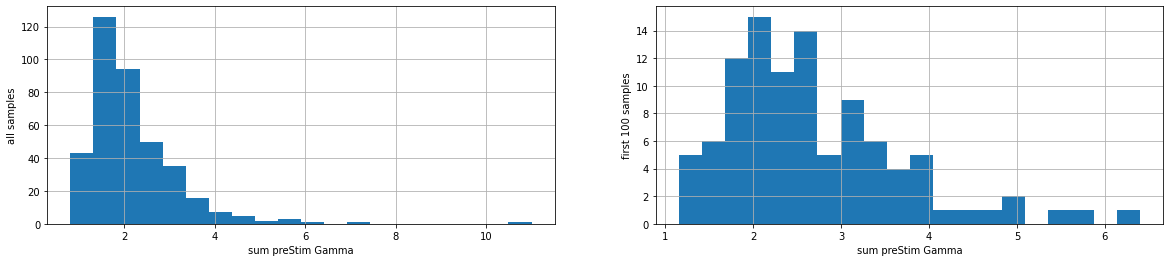

In [7]:
# histogram of raw PSD of preStim gamma
fig = plt.figure(figsize=(20,4));
plt.subplot(1,2,1)
plt.hist(X0_psd, bins=20);
plt.xlabel("sum preStim Gamma")
plt.ylabel("all samples")
plt.grid(visible=True)

plt.subplot(1,2,2)
plt.hist(X0_psd[0:n_used_samples], bins=20);
plt.xlabel("sum preStim Gamma")
plt.ylabel(f"first {'{0:d}'.format(n_used_samples)} samples")
plt.grid(visible=True)
plt.show();

In [9]:
# Balancing Anastesia and Awake samples
# input_data
U1_X0 = U1.join(X0_psd)

U1_X0_sel = U1_X0[0:n_used_samples]
X1_sel = X1[0:n_used_samples]

# def apply_data_mask(U1_X0, X1, n_used_samples):
#     # n_used_samples = 100; 
#     scale = .1
#     f_thresh = 25; g_thresh = 3
#     U1_X0_sel = U1_X0[0:n_used_samples]
#     X1_sel = np.squeeze(X1[0:n_used_samples])
    
#     X1_thresh = np.squeeze(np.array(U1_X0_sel['sum_preStim_gamma'] > g_thresh, dtype = bool))
#     # U1_thresh = U1_X0_sel['Stim_1'] > f_thresh
#     sc= 1+scale*np.sin(np.array(U1_X0_sel.Stim_1)*0.1)*(1/(1+np.exp(-(np.array(U1_X0_sel['sum_preStim_gamma'])-2.5))))
    
#     #X1_sel[X1_thresh] = np.multiply(X1_sel[X1_thresh],sc)
#     X1_sel = np.multiply(X1_sel,sc)
#     #display( np.multiply(X1_sel[X1_thresh],sc))
#     X1_sel = X1_sel.reshape(-1,1)
    
#     return U1_X0_sel, X1_sel


U1_X0_sel, X1_sel = model.apply_data_mask(U1_X0, X1, n_used_samples)
display(U1_X0_sel)
display(np.shape(X1_sel))

,Stim_1,Stim_2,sum_preStim_gamma
0,17,30,3.266571
1,42,40,2.425945
2,35,30,3.117866
3,23,50,2.868627
4,42,50,3.521665
...,...,...,...
95,35,20,3.700448
96,17,20,1.337936
97,5,10,1.672055
98,17,30,3.179625


(100, 1)

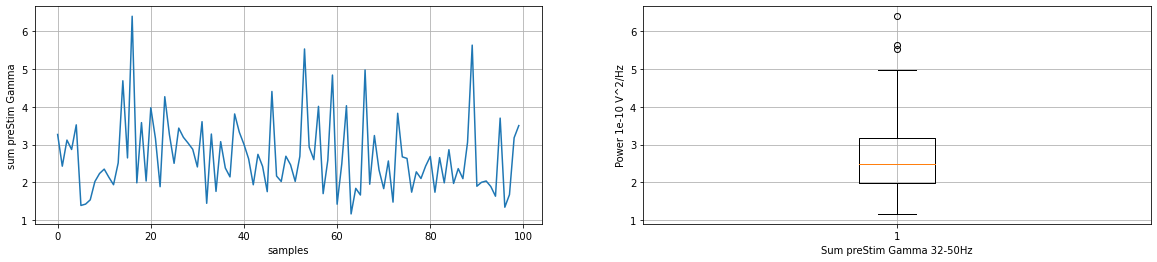

In [10]:
fig = plt.figure(figsize=(20,4));
plt.subplot(1,2,1)
plt.plot(np.arange(0, n_used_samples), U1_X0_sel['sum_preStim_gamma']);
plt.xlabel("samples")
plt.ylabel("sum preStim Gamma")
plt.grid(visible=True)

plt.subplot(1,2,2)
plt.boxplot(U1_X0_sel['sum_preStim_gamma']);
plt.xlabel("Sum preStim Gamma 32-50Hz")
plt.ylabel("Power 1e-10 V^2/Hz")
plt.grid(visible=True)

plt.show();

In [11]:
hill_sum_preStim_gamma = np.empty((n_acquisition))
min_sum_preStim_gamma = np.min(X0_psd['sum_preStim_gamma'])
first_quartile_sum_preStim_gamma = np.quantile(X0_psd['sum_preStim_gamma'], 0.25)
third_quartile_sum_preStim_gamma = np.quantile(X0_psd['sum_preStim_gamma'], 0.75)
# max_sum_preStim_gamma = np.max(X0_psd['sum_preStim_gamma'])
print("min preStimGamma is: \n", min_sum_preStim_gamma, " \n 3rd Quartile preStimGamma is:", 
      third_quartile_sum_preStim_gamma)
half_n_samples = int(n_acquisition/2)
step_size = np.round((third_quartile_sum_preStim_gamma-first_quartile_sum_preStim_gamma)/half_n_samples,6)
# hill_sum_preStim_gamma[0:half_n_samples] = np.arange(min_sum_preStim_gamma, third_quartile_sum_preStim_gamma, step_size)
# hill_sum_preStim_gamma[half_n_samples:n_acquisition] = np.arange(third_quartile_sum_preStim_gamma,
#                                                                      min_sum_preStim_gamma, -step_size)
hill_sum_preStim_gamma[0:half_n_samples] = np.linspace(first_quartile_sum_preStim_gamma, third_quartile_sum_preStim_gamma, half_n_samples)
hill_sum_preStim_gamma[half_n_samples:n_acquisition] = np.flip(np.linspace(first_quartile_sum_preStim_gamma, third_quartile_sum_preStim_gamma, half_n_samples))

print(hill_sum_preStim_gamma[0:3], np.shape(hill_sum_preStim_gamma))

min preStimGamma is: 
 0.8137995193089469  
 3rd Quartile preStimGamma is: 2.5742740008887974
[1.52262311 1.54408538 1.56554764] (100,)


In [12]:
X0_psd_sampled = X0_psd.iloc[0:n_used_samples]
display(X0_psd_sampled['sum_preStim_gamma'])
display(U1_X0_sel['sum_preStim_gamma'])

0     3.266571
1     2.425945
2     3.117866
3     2.868627
4     3.521665
        ...   
95    3.700448
96    1.337936
97    1.672055
98    3.179625
99    3.502282
Name: sum_preStim_gamma, Length: 100, dtype: float64

0     3.266571
1     2.425945
2     3.117866
3     2.868627
4     3.521665
        ...   
95    3.700448
96    1.337936
97    1.672055
98    3.179625
99    3.502282
Name: sum_preStim_gamma, Length: 100, dtype: float64

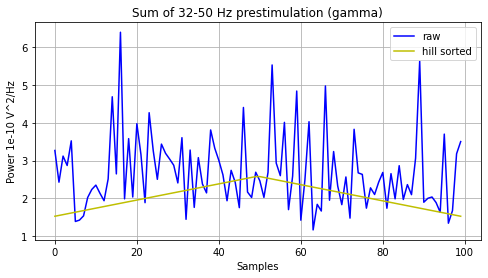

In [13]:
fig = plt.figure(figsize=(8,4));
# plt.plot(np.arange(0, n_used_samples), X0_psd_sampled['sum_preStim_gamma'], color='g');
plt.plot(np.arange(0, n_acquisition), U1_X0_sel['sum_preStim_gamma'][0:n_acquisition], color='b');

plt.plot(np.arange(0, n_acquisition), hill_sum_preStim_gamma, color='y');
plt.xlabel("Samples")
plt.ylabel("Power 1e-10 V^2/Hz")
plt.legend(['raw', 'hill sorted'])
plt.title("Sum of 32-50 Hz prestimulation (gamma)")
plt.grid(visible=True)

In [14]:
print('freq, amplitude and preStim gamma used are: \n', U1_X0_sel[0:4])

freq, amplitude and preStim gamma used are: 
    Stim_1  Stim_2  sum_preStim_gamma
0      17      30           3.266571
1      42      40           2.425945
2      35      30           3.117866
3      23      50           2.868627


In [15]:
print(np.shape(U1_X0_sel))

(100, 3)


## 1.2 First BaO Model is trained on all of the dataset

In [16]:
# ker_RBF = GPy.kern.RBF(input_dim=n_all_parameters, variance=3., lengthscale=2.,ARD=True) + GPy.kern.White(2)
ker_BaO = GPy.kern.Matern52(input_dim=n_all_parameters, variance=3., lengthscale=2.,ARD=True) + GPy.kern.White(2)

In [17]:
slice_dim = 1
ylabel='Predicted Gamma'

#### 1.2.1: The first model uses sum_preStim_gamma.

 C:\Users\sinad\anaconda3\envs\GP_env\lib\site-packages\GPy\plotting\matplot_dep\plot_definitions.py:184: UserWarning:The following kwargs were not used by contour: 'label', 'linewidth'


{'dataplot': [<matplotlib.collections.PathCollection at 0x15d02481400>],
 'gpmean': [<matplotlib.contour.QuadContourSet at 0x15d024814f0>]}

Running L-BFGS-B (Scipy implementation) Code:
  runtime   i      f              |g|        
    00s04  0003   1.331589e+03   4.331236e+04 
    00s11  0009   3.764577e+02   1.919485e+01 
    00s15  0012   3.371363e+02   1.280804e+00 
    00s19  0015   3.228593e+02   2.770307e-01 
    00s37  0040   3.090297e+02   1.356940e-09 
Runtime:     00s37
Optimization status: Converged



{'dataplot': [<matplotlib.collections.PathCollection at 0x15d015e76d0>],
 'gpmean': [<matplotlib.contour.QuadContourSet at 0x15d7f7ca070>]}

(1, 1)
(1, 50)
(1, 100)


{'dataplot': [<matplotlib.collections.PathCollection at 0x15d02191fa0>],
 'gpmean': [<matplotlib.contour.QuadContourSet at 0x15d02178f40>]}

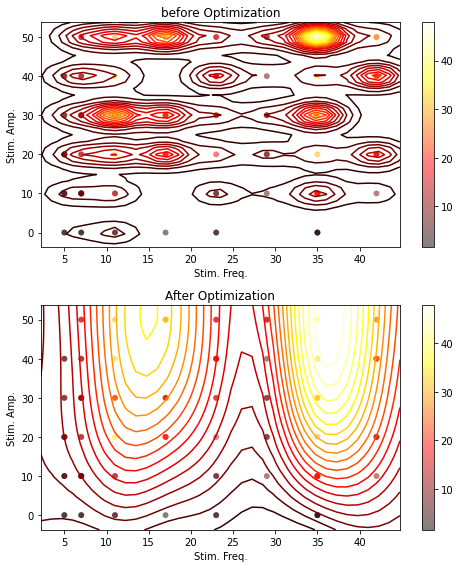

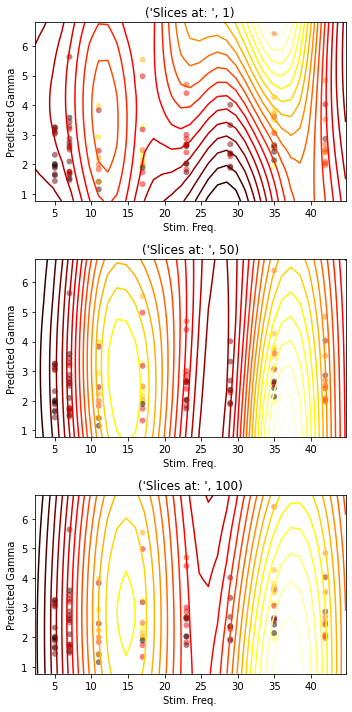

In [18]:
# x_BaO, y_BaO, trained_model_BaO = model.initialize_data_dr_sim(U1, X0_psd, X1, ker_BaO, slice_dim, ylabel)

# create simple GP model
trained_model_BaO = GPy.models.GPRegression(U1_X0_sel,X1_sel,ker_BaO)
figure = GPy.plotting.plotting_library().figure(2, 1, figsize=(7,8))
canvas = trained_model_BaO.plot(figure=figure, visible_dims=[0,1],row=(1),legend=False, xlabel='Stim. Freq.', ylabel='Stim. Amp.',
              title="before Optimization");
display(canvas);
ax = plt.gca()
PCM = ax.get_children()[0]
plt.colorbar(PCM, ax=ax);

# optimize and plot
trained_model_BaO.optimize(messages=True,max_f_eval = 1000);
canvas_optimized = trained_model_BaO.plot(figure=figure, visible_dims=[0,1],row=(2), legend=False, xlabel='Stim. Freq.' , ylabel='Stim. Amp.', 
                title='After Optimization');
display(canvas_optimized)
ax = plt.gca()
PCM = ax.get_children()[0]
plt.colorbar(PCM, ax=ax)

# Plotting slices of the model at amplitudes of 0, 10, and 50
slices = [1, 50, 100]
figure = GPy.plotting.plotting_library().figure(3, 1, figsize=(5,10))

for i, y in zip(range(3), slices):
    print((1,y));

    canvas_slices = trained_model_BaO.plot(figure=figure, fixed_inputs=[(slice_dim, y)], row=(i+1), plot_data=True, legend=False,
                    xlabel='Stim. Freq.', ylabel=ylabel, title=("Slices at: ", y));

display(canvas_slices);

## 1.3: Train the Static model on just the burn-in points, and then use the Acquisition function to pick the next freq/amp 

- The Static model does not use preStimGamma and brain state.
- Then get the suggested freq/amp/preStimGamma from the first model 
- Plot freq/amp/PostStimGamma after 50 interations of acquisition function

In [19]:
# applying data mask

U1_X0 = U1.join(X0_psd)

# U1_X0_sel = U1_X0[0:n_used_samples]
# X1_sel = X1[0:n_used_samples]

U1_X0_sel, X1_sel = model.apply_data_mask(U1_X0, X1, n_used_samples)
U1_sel = U1_X0_sel[['Stim_1','Stim_2']]
display(U1_sel)
display(X1_sel.shape)

,Stim_1,Stim_2
0,17,30
1,42,40
2,35,30
3,23,50
4,42,50
...,...,...
95,35,20
96,17,20
97,5,10
98,17,30


(100, 1)

In [20]:
# chose the first 10 for burn-in/initial training of the model
U1_init = U1_sel.loc[0:n_burn_in-1,:]
# X0_psd_init = X0_psd.loc[0:n_burn_in-1]
X1_init = X1_sel[0:n_burn_in,:]
print( '\n','freq and amplitude used are: \n', U1_init, np.shape(U1_init))
print('sum postStim gamma are: \n', X1_init, np.shape(X1_init))


 freq and amplitude used are: 
     Stim_1  Stim_2
0       17      30
1       42      40
2       35      30
3       23      50
4       42      50
5       35      50
6       11       0
7        7       0
8       17      30
9       11      50
10      17      50
11      35      30
12       5      40
13      42      20
14      23      30
15       7      50
16      35      10
17      17      50
18       7       0
19      42      20 (20, 2)
sum postStim gamma are: 
 [[38.9075469 ]
 [28.28259212]
 [35.3155382 ]
 [17.41537359]
 [26.71258011]
 [47.85447968]
 [ 6.13675736]
 [ 3.01429459]
 [28.70903269]
 [30.25154388]
 [36.50382584]
 [40.34110616]
 [ 8.1601432 ]
 [21.91015639]
 [22.44319194]
 [17.26180094]
 [25.97398224]
 [33.03514638]
 [ 1.87336865]
 [18.62013357]] (20, 1)


In [21]:
# input_data
# U1_X0_init = U1_init.join(X0_psd_init)

In [22]:
print(type(U1_init),type(X1_init))

<class 'pandas.core.frame.DataFrame'> <class 'numpy.ndarray'>


In [65]:
ker_BaO_AF = GPy.kern.Matern52(input_dim=n_parameters_optimizing, variance=3., lengthscale=[7.,10.],ARD=True) + GPy.kern.White(2)
# GPy.kern.RBF(input_dim=n_parameters_optimizing, variance=3., lengthscale=2.,ARD=True) + GPy.kern.White(2)

#### 1.3.1: initial training

Running L-BFGS-B (Scipy implementation) Code:
  runtime   i      f              |g|        
    00s01  0004   3.308938e+02   1.410291e+03 
    00s04  0011   9.108325e+01   3.255394e-01 
    00s04  0013   8.284654e+01   2.982336e-02 
    00s14  0038   7.127080e+01   9.010693e-02 
    00s16  0046   7.063595e+01   6.698837e-05 
    00s19  0056   7.060691e+01   1.462424e-08 
    00s20  0059   7.060691e+01   3.900030e-10 
Runtime:     00s20
Optimization status: Converged



 C:\Users\sinad\anaconda3\envs\GP_env\lib\site-packages\GPy\plotting\matplot_dep\plot_definitions.py:184: UserWarning:The following kwargs were not used by contour: 'label', 'linewidth'


{'dataplot': [<matplotlib.collections.PathCollection at 0x15d086e2b80>],
 'gpmean': [<matplotlib.contour.QuadContourSet at 0x15d084bc340>]}

(1, 1)
(1, 50)
(1, 100)


{'dataplot': [<matplotlib.collections.PathCollection at 0x15d083019d0>],
 'gpmean': [[<matplotlib.lines.Line2D at 0x15d083ced30>]],
 'gpconfidence': [<matplotlib.collections.PolyCollection at 0x15d083cefd0>]}

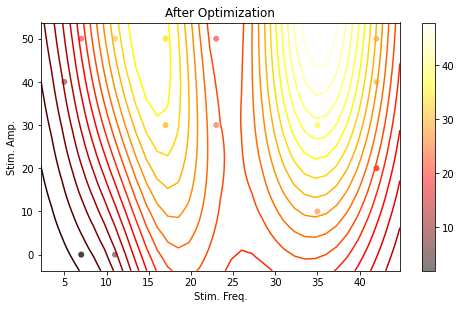

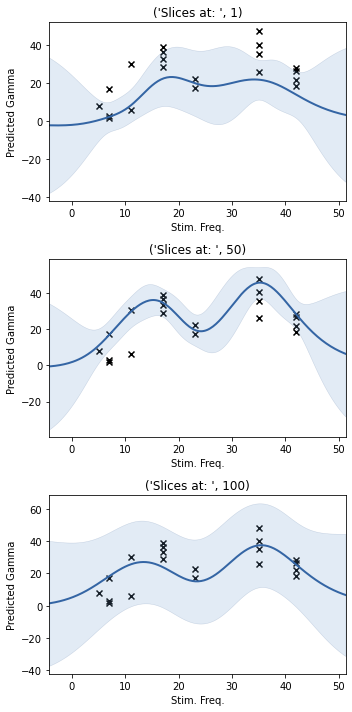

In [66]:
# x_BaO_AF, y_BaO_AF, trained_model_BaO_AF = model.initialize_data_dr_sim(U1_init, X0_psd_init, X1_init, ker_BaO_AF, slice_dim, ylabel)

trained_model_BaO_AF = GPy.models.GPRegression(U1_init,X1_init, ker_BaO_AF)
trained_model_BaO_AF.optimize(messages=True,max_f_eval = 1000);

figure = GPy.plotting.plotting_library().figure(2, 1, figsize=(7,8))
canvas = trained_model_BaO_AF.plot(figure=figure, visible_dims=[0,1],row=(2), legend=False, xlabel='Stim. Freq.' , ylabel='Stim. Amp.', 
                        title='After Optimization');
display(canvas)
ax = plt.gca()
PCM = ax.get_children()[0]
plt.colorbar(PCM, ax=ax)

# Plotting slices of the model at amplitudes of 0, 10, and 50
slices = [1, 50, 100]
figure = GPy.plotting.plotting_library().figure(3, 1, figsize=(5,10))

for i, y in zip(range(3), slices):
    print((1,y));

    canvas = trained_model_BaO_AF.plot(figure=figure, fixed_inputs=[(slice_dim, y)], row=(i+1), plot_data=True, legend=False,
                    xlabel='Stim. Freq.', ylabel=ylabel, title=("Slices at: ", y));

display(canvas);

In [67]:
print(trained_model_BaO_AF.kern.Mat52.lengthscale.values)
print(trained_model_BaO_AF.kern.Mat52.variance.values[0])

[ 9.91912864 78.85756489]
475.09598323538995


#### 1.3.2: Use the acquisition function to guide the next freq to optimize at

In [68]:
rand_freq_1d = np.random.choice([5, 7, 11, 17, 23, 29, 35, 42], size=(50))
rand_freq_1d_sorted = np.sort(rand_freq_1d)
print(rand_freq_1d_sorted, np.shape(rand_freq_1d_sorted))
rand_amp_1d = np.random.choice([10, 20, 30, 40, 50], size=(50))
rand_amp_1d_sorted = np.sort(rand_amp_1d)
print(rand_amp_1d_sorted, np.shape(rand_amp_1d_sorted))
rand_time_1d = np.random.choice(np.arange(0,384),size=(50))
print(rand_time_1d, rand_time_1d.shape)
X_grid_mesh = np.meshgrid(rand_freq_1d_sorted, rand_amp_1d_sorted)
X_grid = np.concatenate((np.asarray(X_grid_mesh[0]).reshape(-1,1), np.asarray(X_grid_mesh[1]).reshape(-1,1)),axis = 1)

X_grid_mesh_t = np.meshgrid(rand_freq_1d_sorted, rand_amp_1d_sorted, rand_time_1d)
X_grid_t = np.concatenate((np.asarray(X_grid_mesh_t[0]).reshape(-1,1), np.asarray(X_grid_mesh_t[1]).reshape(-1,1), np.asarray(X_grid_mesh_t[2]).reshape(-1,1)),axis = 1)
print(np.shape(X_grid), X_grid_t.shape)

[ 5  5  5  5  5  7  7  7  7  7  7 11 11 11 11 11 11 11 11 17 17 17 17 17
 23 23 23 29 29 29 29 29 29 29 35 35 35 35 35 42 42 42 42 42 42 42 42 42
 42 42] (50,)
[10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 20 20 20 20 20 20 20 20 30
 30 30 30 30 30 30 40 40 40 40 40 40 40 40 40 40 40 50 50 50 50 50 50 50
 50 50] (50,)
[241 267 249 135  60  31  46 132 179 308 120 262 306 356 151  89 258 185
 107 256 349 164 222 332  24 157 100 344  32 287  62 148   4 142 302  38
 377 303 339 118   8 157 248 223 350  97 381 126 138 128] (50,)
(2500, 2) (125000, 3)


In [69]:
# print(np.shape(rand_freq_1d_sorted), np.shape(rand_amp_1d_sorted))

# testX_BaO = np.array([rand_freq_1d_sorted, rand_amp_1d_sorted])
# print(np.shape(testX_BaO))
# testX = np.transpose(testX_BaO)
testX = X_grid
print(np.shape(testX))

(2500, 2)


In [70]:
def static_BaO_func(n_samples, n_all_parameters, n_acquisition, testX, hill_sum_preStim_gamma, trained_model_BaO, trained_model_BaO_AF, U1_init, 
                     X1_init, ker_BaO_AF):

    # a loop to optimize at every acquistion for 50 iteration and re-optimization, then plot before and after.
    ucb = np.empty((1, n_samples))
    ucb_sample = np.empty((n_acquisition, n_all_parameters))
    postStimGamma_predicted_from_simulation = np.empty((n_acquisition, 1))
    postStimGamma_predicted_from_simulation_static = np.empty((n_acquisition, 1))
    # print(np.shape(ucb))
    model_sample_static = np.empty((n_acquisition, n_all_parameters))

    nu = 0.1
    # print("nu set at: ", nu)
    static_lengthscale = np.empty((n_parameters_optimizing, n_acquisition))
    static_variance = np.empty((n_acquisition, 1))
    for a in range(0, n_acquisition):
        # print("acquisition #: ", a)
        simY_BaO_AF = np.empty((1, n_samples))
        simMse_BaO_AF = np.empty((1, n_samples))
        simY_BaO_AF, simMse_BaO_AF= trained_model_BaO_AF.predict(testX);

        argMax_model = simY_BaO_AF.argmax()
        model_sample_static[a,:] = np.append(testX[argMax_model],hill_sum_preStim_gamma[a:a+1], axis=0)
        model_sample_static_reshaped = np.reshape(model_sample_static[a,:], (1,n_all_parameters))
        # print("Simulation model prediction: ", model_sample_static_reshaped)

        ucb= model.acquisition_function(simY_BaO_AF, simMse_BaO_AF, nu, 1)
        max_ucb = np.max(ucb, axis=0)
        argMax_ucb = ucb.argmax()
        # find the values of argMax_ucb in the sample grid
        ucb_sample[a,:] = np.append(testX[argMax_ucb],hill_sum_preStim_gamma[a:a+1], axis=0)
        ucb_sample_reshaped = np.reshape(ucb_sample[a,:], (1,n_all_parameters))
        # print("Static model prediction: ", ucb_sample_reshaped)

        # Predicting the Acquisition Func. suggest next freq/amp/preStimGamma from the frist model
        postStimGamma_predicted_from_simulation[a] = trained_model_BaO.posterior_samples_f(model_sample_static_reshaped, full_cov=True, size=1)[:,0,0]
        postStimGamma_predicted_from_simulation_static[a] = trained_model_BaO.posterior_samples_f(ucb_sample_reshaped, full_cov=True, size=1)[:,0,0]
        # simY_BaO, simMse_BaO =  trained_model_BaO.predict(ucb_sample_reshaped);

        # append the acquisition function suggested, and first model predicted mean freq/amp/preStimGamma and mean postStimGamma from state_est_BaO to the burn-in points
        next_sample_to_optimize = pd.DataFrame({'Stim_1':[int(ucb_sample[a,0])], 'Stim_2':[int(ucb_sample[a,1])]})
        U1_init = pd.concat([U1_init, next_sample_to_optimize], ignore_index=True, keys=['Stim_1','Stim_2'], axis=0)

        # Concatenate the first model predicted postStimGamma 
        next_postStimGamma = np.empty((1,1))
        next_postStimGamma[0,:] = [postStimGamma_predicted_from_simulation_static[a]]
        X1_init = np.append(X1_init, next_postStimGamma, axis=0)

        # trained_model_BaO_AF.add_observer()
        trained_model_BaO_AF = model.bayes_opt_update_state(U1_init, X1_init, ker_BaO_AF);
        static_lengthscale[:,a] = trained_model_BaO_AF.kern.Mat52.lengthscale.values
        static_variance[a] = trained_model_BaO_AF.kern.Mat52.variance.values[0]
        
    return trained_model_BaO_AF, model_sample_static, ucb_sample, postStimGamma_predicted_from_simulation, postStimGamma_predicted_from_simulation_static, static_lengthscale, static_variance

In [71]:
trained_model_BaO_AF, model_sample_static, ucb_sample, postStimGamma_predicted_from_simulation, postStimGamma_predicted_from_simulation_static, static_lengthscale, static_variance = static_BaO_func(
    n_samples, n_all_parameters, n_acquisition, testX, hill_sum_preStim_gamma, trained_model_BaO, trained_model_BaO_AF, U1_init, X1_init, ker_BaO_AF)

#### 1.3.3: Plot before and after optimization 

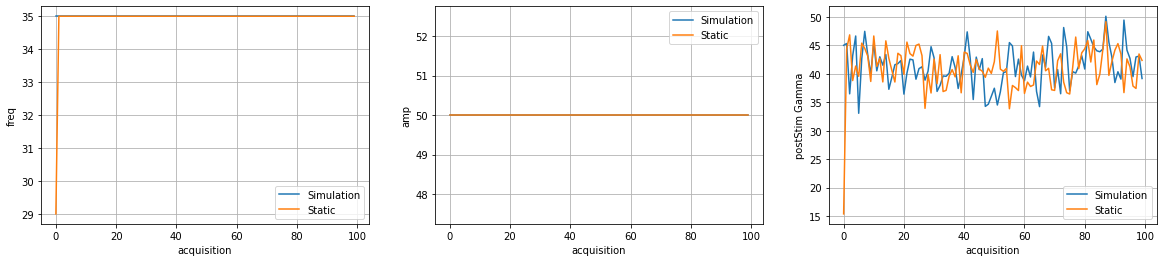

In [72]:
fig = plt.figure(figsize=(20,4));
plt.subplot(1,3,1)
plt.plot(np.arange(0,n_acquisition), model_sample_static[:,0], label=r"frequency")
plt.plot(np.arange(0,n_acquisition), ucb_sample[:,0], label=r"frequency")
plt.xlabel("acquisition")
plt.ylabel("freq")
plt.legend(["Simulation", "Static"])
plt.grid(visible=True)

plt.subplot(1,3,2)
plt.plot(np.arange(0,n_acquisition), model_sample_static[:,1], label=r"amplitude")
plt.plot(np.arange(0,n_acquisition), ucb_sample[:,1], label=r"amplitude")
plt.xlabel("acquisition")
plt.ylabel("amp")
plt.legend(["Simulation", "Static"])
plt.grid(visible=True)

plt.subplot(1,3,3)
plt.plot(np.arange(0,n_acquisition), postStimGamma_predicted_from_simulation, label=r"postStimGamma")
plt.plot(np.arange(0,n_acquisition), postStimGamma_predicted_from_simulation_static, label=r"postStimGamma")
plt.xlabel("acquisition")
plt.ylabel("postStim Gamma")
plt.legend(["Simulation", "Static"])
plt.grid(visible=True)
plt.show();
# plot the model's max (freq, amp, postStim gamma) at each iteration

In [73]:
np.shape(static_lengthscale)

(2, 100)

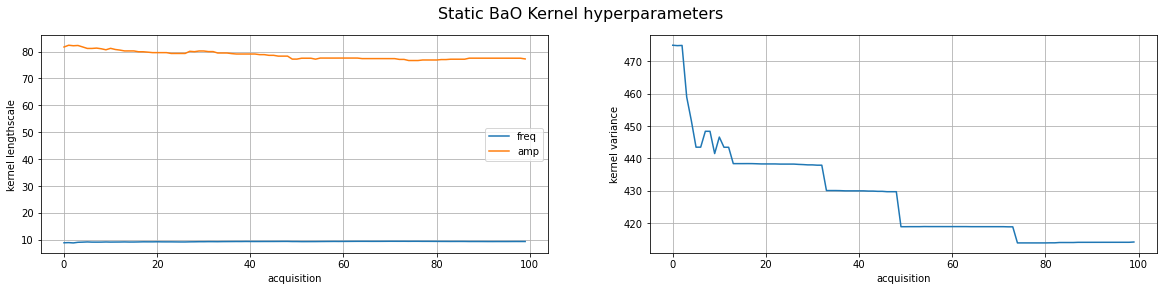

In [74]:
fig = plt.figure(figsize=(20,4));
fig.suptitle("Static BaO Kernel hyperparameters", fontsize=16)
plt.subplot(1,2,1)
plt.plot(np.arange(0,n_acquisition), static_lengthscale[0,:])
plt.plot(np.arange(0,n_acquisition),  static_lengthscale[1,:])
plt.xlabel("acquisition")
plt.ylabel("kernel lengthscale")
plt.legend(["freq", "amp"])
plt.grid(visible=True)

plt.subplot(1,2,2)
plt.plot(np.arange(0,n_acquisition), static_variance)
plt.xlabel("acquisition")
plt.ylabel("kernel variance")
plt.grid(visible=True)

plt.show();

In [75]:
# print(ucb_sample)
print(ucb_sample[1:,0])
print(ucb_sample[1:,1])
# print(ucb_sample[1:,2])

[35. 35. 35. 35. 35. 35. 35. 35. 35. 35. 35. 35. 35. 35. 35. 35. 35. 35.
 35. 35. 35. 35. 35. 35. 35. 35. 35. 35. 35. 35. 35. 35. 35. 35. 35. 35.
 35. 35. 35. 35. 35. 35. 35. 35. 35. 35. 35. 35. 35. 35. 35. 35. 35. 35.
 35. 35. 35. 35. 35. 35. 35. 35. 35. 35. 35. 35. 35. 35. 35. 35. 35. 35.
 35. 35. 35. 35. 35. 35. 35. 35. 35. 35. 35. 35. 35. 35. 35. 35. 35. 35.
 35. 35. 35. 35. 35. 35. 35. 35. 35.]
[50. 50. 50. 50. 50. 50. 50. 50. 50. 50. 50. 50. 50. 50. 50. 50. 50. 50.
 50. 50. 50. 50. 50. 50. 50. 50. 50. 50. 50. 50. 50. 50. 50. 50. 50. 50.
 50. 50. 50. 50. 50. 50. 50. 50. 50. 50. 50. 50. 50. 50. 50. 50. 50. 50.
 50. 50. 50. 50. 50. 50. 50. 50. 50. 50. 50. 50. 50. 50. 50. 50. 50. 50.
 50. 50. 50. 50. 50. 50. 50. 50. 50. 50. 50. 50. 50. 50. 50. 50. 50. 50.
 50. 50. 50. 50. 50. 50. 50. 50. 50.]


In [76]:
print(postStimGamma_predicted_from_simulation_static[1:10])

[[44.33613581]
 [46.82250097]
 [38.8019532 ]
 [41.34681588]
 [39.54520408]
 [45.3666841 ]
 [44.46752925]
 [43.10406414]
 [38.64450396]]


### 1.4: Dynamic BaO

In [77]:
dynamic_model = state_dr_gp()

In [78]:
# Get the input U1 and X0_psd, and the X1 outputs
X0_coords, U1_dynamic, X1_dynamic, lower_bound, upper_bound, X0_psd_dynamic, N_trials = dynamic_model.gp_model(path)

In [79]:
U1_X0_dynamic = U1_dynamic.join(X0_psd_dynamic)
U1_X0_dynamic_sel, X1_dynamic_sel = dynamic_model.apply_data_mask(U1_X0_dynamic, X1_dynamic, n_used_samples)
U1_dynamic_sel = U1_X0_dynamic_sel[['Stim_1','Stim_2']]
display(U1_dynamic_sel)
display(X1_dynamic_sel.shape)

,Stim_1,Stim_2
0,17,30
1,42,40
2,35,30
3,23,50
4,42,50
...,...,...
95,35,20
96,17,20
97,5,10
98,17,30


(100, 1)

#### 1.4.1: We will not use preStimGamma, and instead we will train on most recent 20 samples so the model is not affected by brain state changes.

In [80]:
U1_init_dynamic = U1_dynamic_sel.loc[0:n_burn_in-1,:]
X1_init_dynamic = X1_dynamic_sel[0:n_burn_in,:]
# X0_psd_init_dynamic = X0_psd.loc[0:n_burn_in-1]

print('freq and amplitude used are: \n', U1_init_dynamic, np.shape(U1_init_dynamic))
# print('Sum preStim gamma are: \n', X0_psd_init_dynamic)
print('sum postStim gamma are: \n', X1_init_dynamic, np.shape(X1_init_dynamic))

freq and amplitude used are: 
     Stim_1  Stim_2
0       17      30
1       42      40
2       35      30
3       23      50
4       42      50
5       35      50
6       11       0
7        7       0
8       17      30
9       11      50
10      17      50
11      35      30
12       5      40
13      42      20
14      23      30
15       7      50
16      35      10
17      17      50
18       7       0
19      42      20 (20, 2)
sum postStim gamma are: 
 [[38.9075469 ]
 [28.28259212]
 [35.3155382 ]
 [17.41537359]
 [26.71258011]
 [47.85447968]
 [ 6.13675736]
 [ 3.01429459]
 [28.70903269]
 [30.25154388]
 [36.50382584]
 [40.34110616]
 [ 8.1601432 ]
 [21.91015639]
 [22.44319194]
 [17.26180094]
 [25.97398224]
 [33.03514638]
 [ 1.87336865]
 [18.62013357]] (20, 1)


In [81]:
ker_BaO_dynamic = GPy.kern.Matern52(input_dim=n_parameters_optimizing, variance=3., lengthscale=[7.,10.],ARD=True) + GPy.kern.White(2)
# GPy.kern.RBF(input_dim=n_parameters_optimizing, variance=3., lengthscale=2.,ARD=True) + GPy.kern.White(2)

In [82]:
print(np.shape(U1_init_dynamic))
print(np.shape(X1_init_dynamic))
# print(np.shape(X0_psd_init_dynamic))

(20, 2)
(20, 1)


In [83]:
print(type(U1_init_dynamic),type(X1_init_dynamic))

<class 'pandas.core.frame.DataFrame'> <class 'numpy.ndarray'>


#### 1.4.2: Initial training of the Dynamic model

Running L-BFGS-B (Scipy implementation) Code:
  runtime   i      f              |g|        
    00s01  0004   3.308938e+02   1.410291e+03 
    00s03  0010   9.850950e+01   1.055938e+00 
    00s04  0013   8.284654e+01   2.982336e-02 
    00s12  0038   7.127080e+01   9.010693e-02 
    00s15  0044   7.066242e+01   7.138341e-03 
    00s18  0053   7.060845e+01   4.274470e-04 
    00s20  0059   7.060691e+01   3.900030e-10 
Runtime:     00s20
Optimization status: Converged



 C:\Users\sinad\anaconda3\envs\GP_env\lib\site-packages\GPy\plotting\matplot_dep\plot_definitions.py:184: UserWarning:The following kwargs were not used by contour: 'label', 'linewidth'


{'dataplot': [<matplotlib.collections.PathCollection at 0x15d06a930a0>],
 'gpmean': [<matplotlib.contour.QuadContourSet at 0x15d06a9aac0>]}

(1, 1)
(1, 50)
(1, 100)


{'dataplot': [<matplotlib.collections.PathCollection at 0x15d02732fa0>],
 'gpmean': [[<matplotlib.lines.Line2D at 0x15d02706520>]],
 'gpconfidence': [<matplotlib.collections.PolyCollection at 0x15d02706550>]}

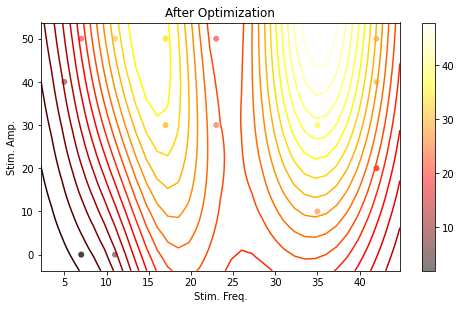

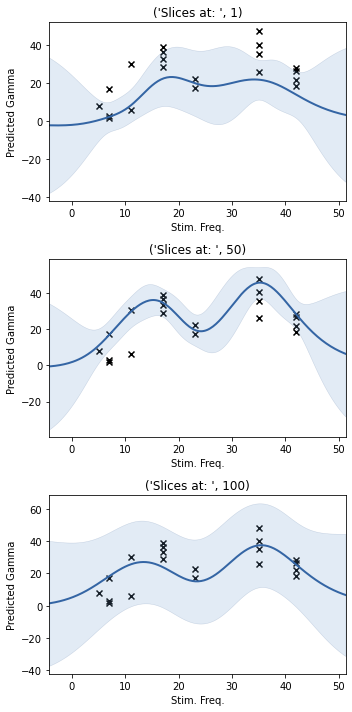

In [84]:
# Initialize a dynamic model:
# x_BaO_dynamic, y_BaO_dynamic, trained_model_BaO_Dynamic = dynamic_model.initialize_data_dr_sim(U1_init_dynamic, X0_psd_init_dynamic, X1_init_dynamic, 
#                                                                                                ker_BaO_dynamic, slice_dim, ylabel)
trained_model_BaO_Dynamic = GPy.models.GPRegression(U1_init_dynamic,X1_init_dynamic, ker_BaO_dynamic)
trained_model_BaO_Dynamic.optimize(messages=True,max_f_eval = 1000);

figure = GPy.plotting.plotting_library().figure(2, 1, figsize=(7,8))
canvas = trained_model_BaO_Dynamic.plot(figure=figure, visible_dims=[0,1],row=(2), legend=False, xlabel='Stim. Freq.' , ylabel='Stim. Amp.', 
                                        title='After Optimization');
display(canvas)
ax = plt.gca()
PCM = ax.get_children()[0]
plt.colorbar(PCM, ax=ax)

# Plotting slices of the model at amplitudes of 0, 10, and 50
slices = [1, 50, 100]
figure = GPy.plotting.plotting_library().figure(3, 1, figsize=(5,10))

for i, y in zip(range(3), slices):
    print((1,y));

    canvas = trained_model_BaO_Dynamic.plot(figure=figure, fixed_inputs=[(slice_dim, y)], row=(i+1), plot_data=True, legend=False,
                    xlabel='Stim. Freq.', ylabel=ylabel, title=("Slices at: ", y));

display(canvas);
# x_BaO_dynamic, y_BaO_dynamic, trained_model_BaO_Dynamic = dynamic_model.initialize_data_dr_sim(U1_init_dynamic, X0_psd_init_dynamic, X1_init_dynamic, 
# ker_BaO, slice_dim, ylabel)

In [85]:
print(np.shape(testX))

(2500, 2)


#### 1.4.3: Using the acquisition function to guide the training of the Dynamic model

In [86]:
def dynamic_BaO_func(n_samples, n_all_parameters, n_acquisition, testX, hill_sum_preStim_gamma, trained_model_BaO, trained_model_BaO_Dynamic, U1_init_dynamic, 
                     X1_init_dynamic, ker_BaO_dynamic):
    
    ucb_dynamic = np.empty((1, n_samples))
    ucb_sample_dynamic = np.empty((n_acquisition, n_all_parameters))
    postStimGamma_predicted_from_simulation_d = np.empty((n_acquisition, 1))
    postStimGamma_predicted_from_simulation_dynamic = np.empty((n_acquisition, 1))
    # print(np.shape(ucb_dynamic))
    model_sample_dynamic = np.empty((n_acquisition, n_all_parameters))

    nu = 0.1
    # print("nu set at: ", nu)
    dynamic_lengthscale = np.empty((n_parameters_optimizing, n_acquisition))
    dynamic_variance = np.empty((n_acquisition, 1))    
    
    for a in range(0, n_acquisition):
        # print("acquisition #: ", a)
        simY_BaO_dynamic = np.empty((1, n_samples))
        simMse_BaO_dynamic = np.empty((1, n_samples))
        simY_BaO_dynamic, simMse_BaO_dynamic= trained_model_BaO_Dynamic.predict(testX);

        argMax_model = simY_BaO_dynamic.argmax()
        model_sample_dynamic[a,:] = np.append(testX[argMax_model],hill_sum_preStim_gamma[a:a+1], axis=0)
        model_sample_dynamic_reshaped = np.reshape(model_sample_dynamic[a,:], (1,n_all_parameters))
        # print("Simulation model prediction: ", model_sample_dynamic_reshaped)    

        ucb_dynamic= dynamic_model.acquisition_function(simY_BaO_dynamic, simMse_BaO_dynamic, nu, 1)
        max_ucb_dynamic = np.max(ucb_dynamic, axis=0)
        argMax_ucb_dynamic = ucb_dynamic.argmax()
        # find the values of argMax_ucb in the sample grid np.append(testX[argMax_ucb],np.zeros([1]), axis=0)
        ucb_sample_dynamic[a, :] = np.append(testX[argMax_ucb_dynamic],hill_sum_preStim_gamma[a:a+1], axis=0)
        ucb_sample_reshaped = np.reshape(ucb_sample_dynamic[a,:], (1,n_all_parameters))
        # print("Dynamic model prediction: ", ucb_sample_reshaped)
        # Predicting the Acquisition Func. suggest next freq/amp/preStimGamma from the frist model
        postStimGamma_predicted_from_simulation_d[a] = trained_model_BaO.posterior_samples_f(model_sample_dynamic_reshaped, full_cov=True, size=1)[:,0,0]
        postStimGamma_predicted_from_simulation_dynamic[a] = trained_model_BaO.posterior_samples_f(ucb_sample_reshaped, full_cov=True, size=1)[:,0,0]
        # print(postStimGamma_predicted_from_simulation_dynamic[a])
        # simY_BaO_dynamic, simMse_BaO_dynamic =  trained_model_BaO_Dynamic.predict(ucb_sample_reshaped);

        # append the acquisition function suggested, and first model predicted mean freq/amp/preStimGamma and mean postStimGamma from state_est_BaO to the burn-in points
        next_sample_to_optimize = pd.DataFrame({'Stim_1':[int(ucb_sample_dynamic[a,0])], 'Stim_2':[int(ucb_sample_dynamic[a,1])]})
        U1_init_dynamic = pd.concat([U1_init_dynamic, next_sample_to_optimize], ignore_index=True, keys=['Stim_1','Stim_2'], axis=0)
        U1_init_dynamic_twenty = U1_init_dynamic.loc[a:a+int(n_samples_to_remember-1),:]

    #     # sum_preStim_gamma
    #     next_preStimGamma_dynamic = pd.DataFrame({'sum_preStim_gamma':[int(ucb_sample_dynamic[a,2])]})
    #     X0_psd_init_dynamic = pd.concat([X0_psd_init_dynamic, next_preStimGamma_dynamic], ignore_index=True, axis=0)
    #     X0_psd_init_dynamic_twenty = X0_psd_init_dynamic.loc[a:a+int(n_burn_in),:]

        # Concatenate the first model predicted postStimGamma 
        next_postStimGamma = np.empty((1,1))
        next_postStimGamma[0,:] = [postStimGamma_predicted_from_simulation_dynamic[a]]
        X1_init_dynamic = np.append(X1_init_dynamic, next_postStimGamma, axis=0)
        # print("X1_init_dynamic shape is: ", np.shape(X1_init_dynamic))

        X1_init_dynamic_twenty = X1_init_dynamic[a:a+int(n_samples_to_remember),:]
        # print(np.shape(U1_init_dynamic_twenty),np.shape(X1_init_dynamic_twenty))
        # trained_model_BaO_AF.add_observer()
        # trained_model_BaO_AF.optimize(messages=True,max_f_eval = 1000)
        trained_model_BaO_Dynamic = dynamic_model.bayes_opt_update_state(U1_init_dynamic_twenty, X1_init_dynamic_twenty, ker_BaO_dynamic)
        dynamic_lengthscale[:,a] = trained_model_BaO_Dynamic.kern.Mat52.lengthscale.values
        dynamic_variance[a] = trained_model_BaO_Dynamic.kern.Mat52.variance.values[0]
        
    return trained_model_BaO_Dynamic, model_sample_dynamic, ucb_sample_dynamic, postStimGamma_predicted_from_simulation_d, postStimGamma_predicted_from_simulation_dynamic, dynamic_lengthscale, dynamic_variance

In [87]:
trained_model_BaO_Dynamic, model_sample_dynamic, ucb_sample_dynamic, postStimGamma_predicted_from_simulation_d, postStimGamma_predicted_from_simulation_dynamic, dynamic_lengthscale, dynamic_variance = dynamic_BaO_func(
    n_samples, n_all_parameters, n_acquisition, testX, hill_sum_preStim_gamma, trained_model_BaO, trained_model_BaO_Dynamic, U1_init_dynamic, X1_init_dynamic, ker_BaO_dynamic)

 C:\Users\sinad\anaconda3\envs\GP_env\lib\site-packages\paramz\transformations.py:111: RuntimeWarning:overflow encountered in expm1


In [88]:
# testX[argMax_ucb_dynamic]
print(np.shape(dynamic_lengthscale))

(2, 100)


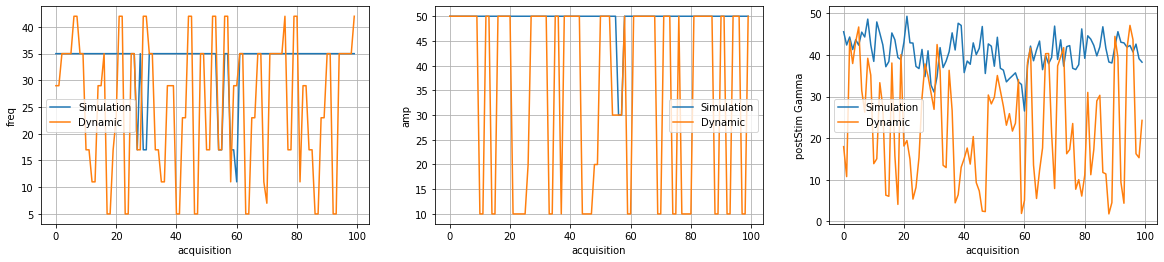

In [89]:
fig = plt.figure(figsize=(20,4));
plt.subplot(1,3,1)
plt.plot(np.arange(0,n_acquisition), model_sample_dynamic[:,0], label=r"frequency")
plt.plot(np.arange(0,n_acquisition), ucb_sample_dynamic[:,0], label=r"frequency")
plt.xlabel("acquisition")
plt.ylabel("freq")
plt.legend(["Simulation", "Dynamic"])
plt.grid(visible=True)

plt.subplot(1,3,2)
plt.plot(np.arange(0,n_acquisition), model_sample_dynamic[0:,1], label=r"amplitude")
plt.plot(np.arange(0,n_acquisition), ucb_sample_dynamic[0:,1], label=r"amplitude")
plt.xlabel("acquisition")
plt.ylabel("amp")
plt.legend(["Simulation", "Dynamic"])
plt.grid(visible=True)

plt.subplot(1,3,3)
plt.plot(np.arange(0,n_acquisition), postStimGamma_predicted_from_simulation_d, label=r"postStimGamma")
plt.plot(np.arange(0,n_acquisition), postStimGamma_predicted_from_simulation_dynamic, label=r"postStimGamma")
plt.xlabel("acquisition")
plt.ylabel("postStim Gamma")
plt.legend(["Simulation", "Dynamic"])
plt.grid(visible=True)
plt.show()

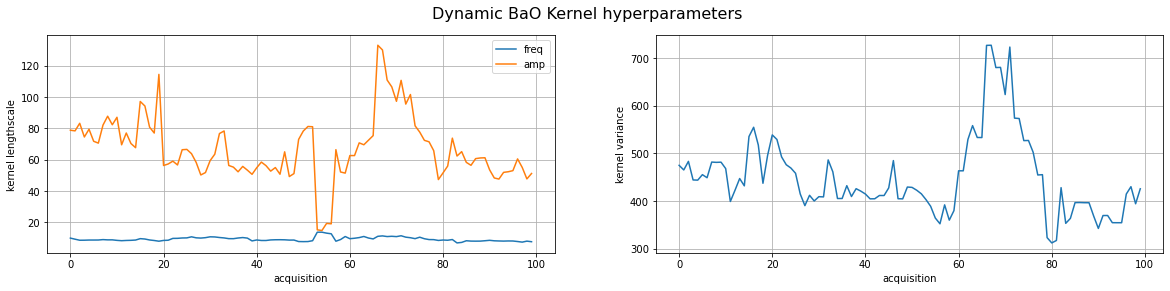

In [90]:
fig = plt.figure(figsize=(20,4));
fig.suptitle("Dynamic BaO Kernel hyperparameters", fontsize=16)
plt.subplot(1,2,1)
plt.plot(np.arange(0,n_acquisition), dynamic_lengthscale[0,:])
plt.plot(np.arange(0,n_acquisition),  dynamic_lengthscale[1,:])
plt.xlabel("acquisition")
plt.ylabel("kernel lengthscale")
plt.legend(["freq", "amp"])
plt.grid(visible=True)

plt.subplot(1,2,2)
plt.plot(np.arange(0,n_acquisition), dynamic_variance)
plt.xlabel("acquisition")
plt.ylabel("kernel variance")
plt.grid(visible=True)

plt.show();

 C:\Users\sinad\anaconda3\envs\GP_env\lib\site-packages\GPy\plotting\matplot_dep\plot_definitions.py:184: UserWarning:The following kwargs were not used by contour: 'label', 'linewidth'


{'dataplot': [<matplotlib.collections.PathCollection at 0x15d06aaaee0>],
 'gpmean': [<matplotlib.contour.QuadContourSet at 0x15d06836fd0>]}

(1, 1)
(1, 50)
(1, 100)


{'dataplot': [<matplotlib.collections.PathCollection at 0x15d08358f40>],
 'gpmean': [[<matplotlib.lines.Line2D at 0x15d06842610>]],
 'gpconfidence': [<matplotlib.collections.PolyCollection at 0x15d06842640>]}

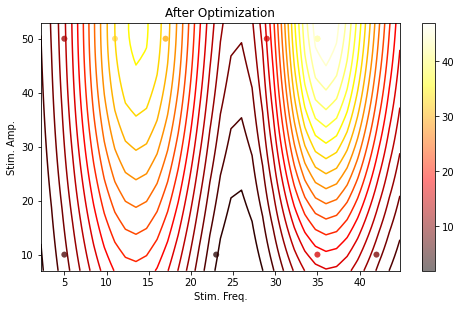

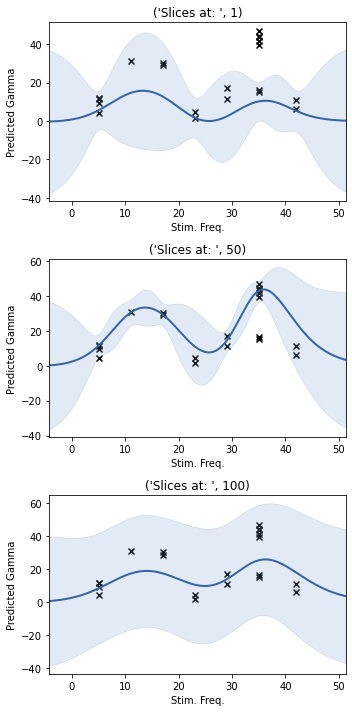

In [91]:
figure = GPy.plotting.plotting_library().figure(2, 1, figsize=(7,8))
canvas = trained_model_BaO_Dynamic.plot(figure=figure, visible_dims=[0,1],row=(2), legend=False, xlabel='Stim. Freq.' , ylabel='Stim. Amp.', 
                        title='After Optimization');
display(canvas)
ax = plt.gca()
PCM = ax.get_children()[0]
plt.colorbar(PCM, ax=ax)

# Plotting slices of the model at amplitudes of 0, 10, and 50
slices = [1, 50, 100]
figure = GPy.plotting.plotting_library().figure(3, 1, figsize=(5,10))

for i, y in zip(range(3), slices):
    print((1,y));

    canvas = trained_model_BaO_Dynamic.plot(figure=figure, fixed_inputs=[(slice_dim, y)], row=(i+1), plot_data=True, legend=False,
                    xlabel='Stim. Freq.', ylabel=ylabel, title=("Slices at: ", y));

display(canvas);

### 1.5: Adaptive BaO

In [114]:
adaptive_model = state_dr_gp()

In [115]:
# Get the input U1 and X0_psd, and the X1 outputs
X0_coords, U1_adaptive, X1_adaptive, lower_bound, upper_bound, X0_psd_adaptive, N_trials = adaptive_model.gp_model(path)

In [116]:
U1_X0_adaptive = U1_adaptive.join(X0_psd_adaptive)
U1_X0_adaptive_sel, X1_adaptive_sel = adaptive_model.apply_data_mask(U1_X0_adaptive, X1_adaptive, n_used_samples)
U1_adaptive_sel = U1_X0_adaptive_sel[['Stim_1','Stim_2']]

In [117]:
time = np.arange(0, n_acquisition)
print(time.shape)
U1_adaptive_sel['time'] = time
print(U1_adaptive_sel.shape)
U1_adaptive_sel

(100,)
(100, 3)


,Stim_1,Stim_2,time
0,17,30,0
1,42,40,1
2,35,30,2
3,23,50,3
4,42,50,4
...,...,...,...
95,35,20,95
96,17,20,96
97,5,10,97
98,17,30,98


In [118]:
U1_init_adaptive = U1_adaptive_sel.loc[0:n_burn_in-1,:]
X1_init_adaptive = X1_adaptive_sel[0:n_burn_in,:]


In [119]:
print(np.shape(U1_init_adaptive))
print(np.shape(X1_init_adaptive))


(20, 3)
(20, 1)


In [120]:
ker_BaO_adaptive = GPy.kern.Matern52(input_dim=3, variance=3., lengthscale=[7.,10., 20.],ARD=True) + GPy.kern.White(3)

#### 1.5.1: Initial Training of the Adaptive Model

Running L-BFGS-B (Scipy implementation) Code:
  runtime   i      f              |g|        
    00s01  0004   3.388494e+02   1.503381e+03 
    00s05  0011   9.178871e+01   3.459720e-01 
    00s06  0013   8.313043e+01   3.134151e-02 
    00s19  0035   1.797002e+02   5.109329e+01 
    00s38  0098   7.060692e+01   4.119210e-08 
Runtime:     00s38
Optimization status: Converged



 C:\Users\sinad\anaconda3\envs\GP_env\lib\site-packages\GPy\plotting\matplot_dep\plot_definitions.py:184: UserWarning:The following kwargs were not used by contour: 'label', 'linewidth'


{'dataplot': [<matplotlib.collections.PathCollection at 0x15d08fdd9a0>],
 'gpmean': [<matplotlib.contour.QuadContourSet at 0x15d08fd3490>]}

(1, 1)
(1, 50)
(1, 100)


{'dataplot': [<matplotlib.collections.PathCollection at 0x15d0916ffa0>],
 'gpmean': [<matplotlib.contour.QuadContourSet at 0x15d091537f0>]}

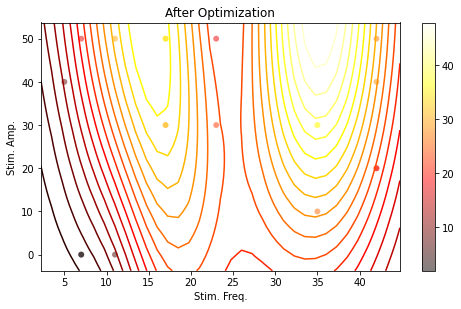

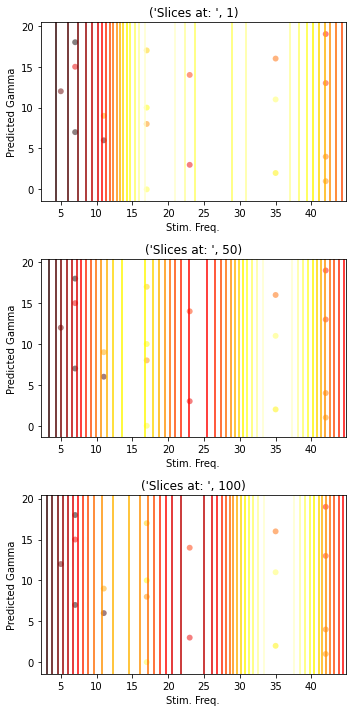

In [121]:
# Initialize the adaptive model:

trained_model_BaO_adaptive = GPy.models.GPRegression(U1_init_adaptive,X1_init_adaptive, ker_BaO_adaptive)
trained_model_BaO_adaptive.optimize(messages=True,max_f_eval = 1000);

figure = GPy.plotting.plotting_library().figure(2, 1, figsize=(7,8))
canvas = trained_model_BaO_adaptive.plot(figure=figure, visible_dims=[0,1],row=(2), legend=False, xlabel='Stim. Freq.' , ylabel='Stim. Amp.', 
                                        title='After Optimization');
display(canvas)
ax = plt.gca()
PCM = ax.get_children()[0]
plt.colorbar(PCM, ax=ax)

# Plotting slices of the model at amplitudes of 0, 10, and 50
slices = [1, 50, 100]
figure = GPy.plotting.plotting_library().figure(3, 1, figsize=(5,10))

for i, y in zip(range(3), slices):
    print((1,y));

    canvas = trained_model_BaO_adaptive.plot(figure=figure, fixed_inputs=[(slice_dim, y)], row=(i+1), plot_data=True, legend=False,
                    xlabel='Stim. Freq.', ylabel=ylabel, title=("Slices at: ", y));

display(canvas);

#### 1.5.2: Using the acquisition function to guide the training of the Adaptive model

In [122]:
# making a testX with time
testX_t=X_grid_t
testX_t.shape
print(n_all_parameters)
n_all_parameters_t = 4
print(n_all_parameters_t)
n_parameters_optimizing_t = 3

3
4


In [123]:
def adaptive_BaO_func(n_samples, n_all_parameters, n_acquisition, testX, hill_sum_preStim_gamma, trained_model_BaO, trained_model_BaO_adaptive, U1_init_adaptive, 
                     X1_init_adaptive, ker_BaO_adaptive):
    
    ucb_adaptive = np.empty((1, n_samples))
    ucb_sample_adaptive = np.empty((n_acquisition, n_all_parameters))
    postStimGamma_predicted_from_simulation_a = np.empty((n_acquisition, 1))
    postStimGamma_predicted_from_simulation_adaptive = np.empty((n_acquisition, 1))
    model_sample_adaptive = np.empty((n_acquisition, n_all_parameters))

    nu = 0.1
    # print("nu set at: ", nu)
    adaptive_lengthscale = np.empty((n_parameters_optimizing_t, n_acquisition))
    adaptive_variance = np.empty((n_acquisition, 1))    
    
    for a in range(0, n_acquisition):
        # print("acquisition #: ", a)
        simY_BaO_adaptive = np.empty((1, n_samples))
        simMse_BaO_adaptive = np.empty((1, n_samples))
        simY_BaO_adaptive, simMse_BaO_adaptive = trained_model_BaO_adaptive.predict(testX);

        argMax_model = simY_BaO_adaptive.argmax()
        model_sample_adaptive[a,:] = np.append(testX[argMax_model],hill_sum_preStim_gamma[a:a+1], axis=0)
        model_sample_adaptive_reshaped = np.reshape(model_sample_adaptive[a,:], (1,n_all_parameters))    

        ucb_adaptive = adaptive_model.acquisition_function(simY_BaO_adaptive, simMse_BaO_adaptive, nu, 1)
        max_ucb_adaptive = np.max(ucb_adaptive, axis=0)
        argMax_ucb_adaptive = ucb_adaptive.argmax()
        # find the values of argMax_ucb in the sample grid np.append(testX[argMax_ucb],np.zeros([1]), axis=0)
        ucb_sample_adaptive[a, :] = np.append(testX[argMax_ucb_adaptive],hill_sum_preStim_gamma[a:a+1], axis=0)
        ucb_sample_reshaped = np.reshape(ucb_sample_adaptive[a,:], (1,n_all_parameters))
     
        # Predicting the Acquisition Func. suggest next freq/amp/preStimGamma from the frist model
        postStimGamma_predicted_from_simulation_a[a] = trained_model_BaO.posterior_samples_f(model_sample_adaptive_reshaped, full_cov=True, size=1)[:,0,0]
        postStimGamma_predicted_from_simulation_adaptive[a] = trained_model_BaO.posterior_samples_f(ucb_sample_reshaped, full_cov=True, size=1)[:,0,0]

        # append the acquisition function suggested, and first model predicted mean freq/amp/preStimGamma and mean postStimGamma from state_est_BaO to the burn-in points
        next_sample_to_optimize = pd.DataFrame({'Stim_1':[int(ucb_sample_adaptive[a,0])], 'Stim_2':[int(ucb_sample_adaptive[a,1])], 'time':[int(ucb_sample_adaptive[a,2])]})
        U1_init_adaptive = pd.concat([U1_init_adaptive, next_sample_to_optimize], ignore_index=True, keys=['Stim_1','Stim_2','time'], axis=0)
        # U1_init_adaptive_twenty = U1_init_adaptive.loc[a:a+int(n_samples_to_remember-1),:]

        # Concatenate the first model predicted postStimGamma 
        next_postStimGamma = np.empty((1,1))
        next_postStimGamma[0,:] = [postStimGamma_predicted_from_simulation_adaptive[a]]
        X1_init_adaptive = np.append(X1_init_adaptive, next_postStimGamma, axis=0)

        # X1_init_adaptive_twenty = X1_init_adaptive[a:a+int(n_samples_to_remember),:]
        trained_model_BaO_adaptive = adaptive_model.bayes_opt_update_state(U1_init_adaptive, X1_init_adaptive, ker_BaO_adaptive)
        adaptive_lengthscale[:,a] = trained_model_BaO_adaptive.kern.Mat52.lengthscale.values
        adaptive_variance[a] = trained_model_BaO_adaptive.kern.Mat52.variance.values[0]
        
    return trained_model_BaO_adaptive, model_sample_adaptive, ucb_sample_adaptive, postStimGamma_predicted_from_simulation_a, postStimGamma_predicted_from_simulation_adaptive, adaptive_lengthscale, adaptive_variance

In [124]:
trained_model_BaO_adaptive, model_sample_adaptive, ucb_sample_adaptive, postStimGamma_predicted_from_simulation_a, postStimGamma_predicted_from_simulation_adaptive, adaptive_lengthscale, adaptive_variance = adaptive_BaO_func(
    n_samples, n_all_parameters_t, n_acquisition, testX_t, hill_sum_preStim_gamma, trained_model_BaO, trained_model_BaO_adaptive, U1_init_adaptive, X1_init_adaptive, ker_BaO_adaptive)

 C:\Users\sinad\anaconda3\envs\GP_env\lib\site-packages\paramz\transformations.py:111: RuntimeWarning:overflow encountered in expm1


### 1.6: comparing static and adaptive BaO

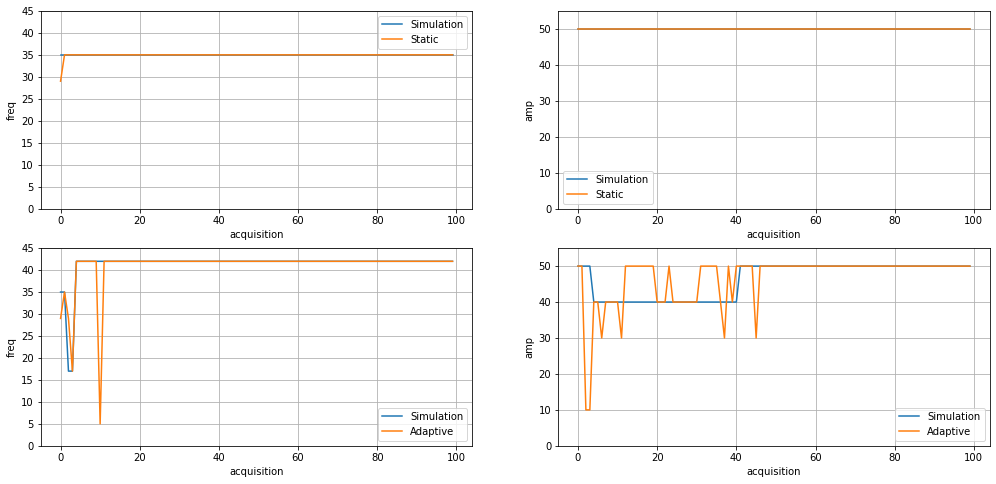

In [125]:
fig = plt.figure(figsize=(17,8));
fig.title = ("Simulation vs. Static/Dynamic BaO")
plt.subplot(2,2,1)
plt.plot(np.arange(0,n_acquisition), model_sample_static[:,0], label=r"frequency")
plt.plot(np.arange(0,n_acquisition), ucb_sample[:,0], label=r"frequency")
plt.ylim([0, 45])
plt.xlabel("acquisition")
plt.ylabel("freq")
plt.legend(["Simulation", "Static"])
plt.grid(visible=True)

plt.subplot(2,2,2)
plt.plot(np.arange(0,n_acquisition), model_sample_static[:,1], label=r"amplitude")
plt.plot(np.arange(0,n_acquisition), ucb_sample[:,1], label=r"amplitude")
plt.ylim([0, 55])
plt.xlabel("acquisition")
plt.ylabel("amp")
plt.legend(["Simulation", "Static"])
plt.grid(visible=True)

plt.subplot(2,2,3)
plt.plot(np.arange(0,n_acquisition), model_sample_adaptive[:,0], label=r"frequency")
plt.plot(np.arange(0,n_acquisition), ucb_sample_adaptive[:,0], label=r"frequency")
plt.ylim([0, 45])
plt.xlabel("acquisition")
plt.ylabel("freq")
plt.legend(["Simulation", "Adaptive"])
plt.grid(visible=True)

plt.subplot(2,2,4)
plt.plot(np.arange(0,n_acquisition), model_sample_adaptive[:,1], label=r"amplitude")
plt.plot(np.arange(0,n_acquisition), ucb_sample_adaptive[:,1], label=r"amplitude")
plt.ylim([0, 55])
plt.xlabel("acquisition")
plt.ylabel("amp")
plt.legend(["Simulation", "Adaptive"])
plt.grid(visible=True)

plt.show()


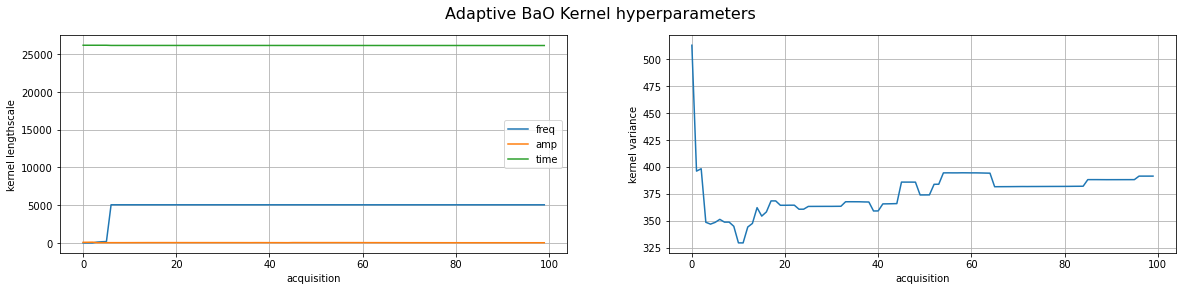

In [126]:
fig = plt.figure(figsize=(20,4));
fig.suptitle("Adaptive BaO Kernel hyperparameters", fontsize=16)
plt.subplot(1,2,1)
plt.plot(np.arange(0,n_acquisition), adaptive_lengthscale[0,:])
plt.plot(np.arange(0,n_acquisition), adaptive_lengthscale[1,:])
plt.plot(np.arange(0,n_acquisition), adaptive_lengthscale[2,:])
plt.xlabel("acquisition")
plt.ylabel("kernel lengthscale")
plt.legend(["freq", "amp","time"])
plt.grid(visible=True)

plt.subplot(1,2,2)
plt.plot(np.arange(0,n_acquisition), adaptive_variance)
plt.xlabel("acquisition")
plt.ylabel("kernel variance")
plt.grid(visible=True)

plt.show();

### 1.7: Experiment Loop 

In [105]:
print(np.shape(model_sample_static))

(100, 3)


In [127]:
# Initialize variables:
# reshape variables
static_sample = np.empty((n_acquisition, n_all_parameters, n_exp_runs))
dynamic_sample = np.empty((n_acquisition, n_all_parameters, n_exp_runs))
adaptive_sample = np.empty((n_acquisition, n_all_parameters_t, n_exp_runs))
simulation_postStimGamma_predicted = np.empty((n_acquisition, 1, n_exp_runs))
static_postStimGamma_predicted = np.empty((n_acquisition, 1, n_exp_runs))

static_ucb = np.empty((n_acquisition, n_all_parameters, n_exp_runs))
dynamic_ucb = np.empty((n_acquisition, n_all_parameters, n_exp_runs))
adaptive_ucb = np.empty((n_acquisition, n_all_parameters_t, n_exp_runs))
simulation_postStimGamma_predicted_d = np.empty((n_acquisition, 1, n_exp_runs))
dynamic_postStimGamma_predicted = np.empty((n_acquisition, 1, n_exp_runs))
simulation_postStimGamma_predicted_a = np.empty((n_acquisition, 1, n_exp_runs))
adaptive_postStimGamma_predicted = np.empty((n_acquisition, 1, n_exp_runs))

static_lengthscale = np.empty((n_parameters_optimizing, n_acquisition, n_exp_runs))
static_variance = np.empty((n_acquisition, 1, n_exp_runs))
dynamic_lengthscale = np.empty((n_parameters_optimizing, n_acquisition, n_exp_runs))
dynamic_variance = np.empty((n_acquisition, 1, n_exp_runs))
adaptive_lengthscale = np.empty((n_parameters_optimizing_t, n_acquisition, n_exp_runs))
adaptive_variance = np.empty((n_acquisition, 1, n_exp_runs))

for e in range(0, n_exp_runs): #n_exp_runs
    print('Experiment run: ', e)
    
#     Initial training for satic: trained_model_BaO_AF, ker_BaO_AF
    U1_init = U1_sel.loc[0:n_burn_in-1,:]
    X1_init = X1_sel[0:n_burn_in,:]
    ker_BaO_AF = GPy.kern.Matern52(input_dim=n_parameters_optimizing, variance=3., lengthscale=[10.,80.],ARD=True) + GPy.kern.White(2)
    trained_model_BaO_AF = GPy.models.GPRegression(U1_init,X1_init, ker_BaO_AF)
    trained_model_BaO_AF.optimize(messages=True,max_f_eval = 1000);
    
    U1_init_dynamic = U1_dynamic_sel.loc[0:n_burn_in-1,:]
    X1_init_dynamic = X1_dynamic_sel[0:n_burn_in,:]
    ker_BaO_dynamic = GPy.kern.Matern52(input_dim=n_parameters_optimizing, variance=3., lengthscale=[10.,80.],ARD=True) + GPy.kern.White(2)
    trained_model_BaO_Dynamic = GPy.models.GPRegression(U1_init_dynamic,X1_init_dynamic, ker_BaO_dynamic)
    trained_model_BaO_Dynamic.optimize(messages=True,max_f_eval = 1000);
    
    U1_init_adaptive = U1_adaptive_sel.loc[0:n_burn_in-1,:]
    X1_init_adaptive = X1_adaptive_sel[0:n_burn_in,:]
    ker_BaO_adaptive = GPy.kern.Matern52(input_dim=n_parameters_optimizing_t, variance=3., lengthscale=[10.,80., 250.],ARD=True) + GPy.kern.White(3)
    trained_model_BaO_adaptive = GPy.models.GPRegression(U1_init_adaptive,X1_init_adaptive, ker_BaO_adaptive)
    trained_model_BaO_adaptive.optimize(messages=True,max_f_eval = 1000);
    
    _, static_sample[:,:,e], static_ucb[:,:,e], simulation_postStimGamma_predicted[:,:,e], static_postStimGamma_predicted[:,:,e], static_lengthscale[:,:,e], static_variance[:,0:1,e] = static_BaO_func(
        n_samples, n_all_parameters, n_acquisition, testX, hill_sum_preStim_gamma, trained_model_BaO, trained_model_BaO_AF, U1_init, X1_init, ker_BaO_AF)
    
    _, dynamic_sample[:,:,e], dynamic_ucb[:,:,e], simulation_postStimGamma_predicted_d[:,:,e], dynamic_postStimGamma_predicted[:,:,e], dynamic_lengthscale[:,:,e], dynamic_variance[:,0:1,e]  = dynamic_BaO_func(
        n_samples, n_all_parameters, n_acquisition, testX, hill_sum_preStim_gamma, trained_model_BaO, trained_model_BaO_Dynamic, U1_init_dynamic, X1_init_dynamic, ker_BaO_dynamic)
    
    _, adaptive_sample[:,:,e], adaptive_ucb[:,:,e], simulation_postStimGamma_predicted_a[:,:,e], adaptive_postStimGamma_predicted[:,:,e], adaptive_lengthscale[:,:,e], adaptive_variance[:,0:1,e]  = adaptive_BaO_func(
        n_samples, n_all_parameters_t, n_acquisition, testX_t, hill_sum_preStim_gamma, trained_model_BaO, trained_model_BaO_adaptive, U1_init_adaptive, X1_init_adaptive, ker_BaO_adaptive)
        
    print('end of run. \n ----------------------------------------')

Experiment run:  0
Running L-BFGS-B (Scipy implementation) Code:
  runtime   i      f              |g|        
    00s00  0001   5.184734e+02   1.529496e+04 
    00s02  0006   1.569478e+02   5.411642e+01 
    00s09  0019   7.670185e+01   7.705665e-03 
    00s19  0034   8.166078e+01   4.052619e+01 
    00s27  0056   7.060691e+01   2.343336e-12 
Runtime:     00s27
Optimization status: Converged

Running L-BFGS-B (Scipy implementation) Code:
  runtime   i      f              |g|        
    00s01  0002   4.176649e+02   6.690883e+03 
    00s05  0008   1.145986e+02   5.241122e+00 
    00s08  0014   7.929303e+01   3.676584e-03 
    00s19  0032   7.343911e+01   8.374467e-01 
    00s29  0056   7.060691e+01   2.343336e-12 
Runtime:     00s29
Optimization status: Converged

Running L-BFGS-B (Scipy implementation) Code:
  runtime   i      f              |g|        
    00s05  0008   1.146016e+02   5.240981e+00 
    00s06  0010   9.362362e+01   4.879172e-01 
    00s09  0015   7.799908e+01   1.0768

 C:\Users\sinad\anaconda3\envs\GP_env\lib\site-packages\paramz\transformations.py:111: RuntimeWarning:overflow encountered in expm1


end of run. 
 ----------------------------------------
Experiment run:  1
Running L-BFGS-B (Scipy implementation) Code:
  runtime   i      f              |g|        
    00s01  0001   5.184734e+02   1.529496e+04 
    00s06  0009   1.020056e+02   1.586874e+00 
    00s13  0017   8.062016e+01   5.626430e-03 
    00s19  0023   7.578267e+01   1.004611e+00 
    00s43  0056   7.060691e+01   2.343336e-12 
Runtime:     00s43
Optimization status: Converged

Running L-BFGS-B (Scipy implementation) Code:
  runtime   i      f              |g|        
    00s04  0003   3.019558e+02   1.718325e+03 
    00s12  0010   9.361969e+01   4.878490e-01 
    00s18  0015   7.799498e+01   1.076987e-03 
    00s19  0017   8.062016e+01   5.626430e-03 
    00s52  0056   7.060691e+01   2.343336e-12 
Runtime:     00s52
Optimization status: Converged

Running L-BFGS-B (Scipy implementation) Code:
  runtime   i      f              |g|        
    00s02  0002   4.177053e+02   6.690932e+03 
    00s14  0010   9.362362e+01 

 C:\Users\sinad\anaconda3\envs\GP_env\lib\site-packages\GPy\kern\src\stationary.py:137: RuntimeWarning:overflow encountered in square
 C:\Users\sinad\anaconda3\envs\GP_env\lib\site-packages\GPy\kern\src\stationary.py:138: RuntimeWarning:invalid value encountered in add
 C:\Users\sinad\anaconda3\envs\GP_env\lib\site-packages\GPy\kern\src\stationary.py:166: RuntimeWarning:overflow encountered in true_divide
 C:\Users\sinad\anaconda3\envs\GP_env\lib\site-packages\GPy\kern\src\stationary.py:243: RuntimeWarning:invalid value encountered in true_divide


end of run. 
 ----------------------------------------
Experiment run:  2
Running L-BFGS-B (Scipy implementation) Code:
  runtime   i      f              |g|        
    00s01  0003   3.019558e+02   1.718325e+03 
    00s06  0011   8.797663e+01   1.514679e-01 
    00s10  0017   8.062016e+01   5.626430e-03 
    00s17  0027   7.578267e+01   1.004611e+00 
    00s35  0056   7.060691e+01   2.343336e-12 
Runtime:     00s35
Optimization status: Converged

Running L-BFGS-B (Scipy implementation) Code:
  runtime   i      f              |g|        
    00s07  0009   1.020056e+02   1.586874e+00 
    00s12  0016   7.725377e+01   1.260322e-03 
    00s19  0023   7.578267e+01   1.004611e+00 
    00s41  0056   7.060691e+01   2.343336e-12 
Runtime:     00s41
Optimization status: Converged

Running L-BFGS-B (Scipy implementation) Code:
  runtime   i      f              |g|        
    00s10  0010   9.362362e+01   4.879172e-01 
    00s14  0014   7.929651e+01   3.677397e-03 
    00s19  0019   7.681220e+01 

 C:\Users\sinad\anaconda3\envs\GP_env\lib\site-packages\GPy\kern\src\stationary.py:581: RuntimeWarning:invalid value encountered in multiply


end of run. 
 ----------------------------------------
Experiment run:  3
Running L-BFGS-B (Scipy implementation) Code:
  runtime   i      f              |g|        
    00s03  0005   1.903742e+02   1.707296e+02 
    00s07  0011   8.797663e+01   1.514679e-01 
    00s13  0020   8.027799e+01   1.676510e+00 
    00s19  0028   1.918567e+06   1.838516e+12 
    00s32  0056   7.060691e+01   2.343336e-12 
Runtime:     00s32
Optimization status: Converged

Running L-BFGS-B (Scipy implementation) Code:
  runtime   i      f              |g|        
    00s04  0006   1.569478e+02   5.411642e+01 
    00s08  0011   8.797663e+01   1.514679e-01 
    00s19  0024   3.835573e+09   1.287112e+06 
    00s38  0056   7.060691e+01   2.343336e-12 
Runtime:     00s38
Optimization status: Converged

Running L-BFGS-B (Scipy implementation) Code:
  runtime   i      f              |g|        
    00s02  0002   4.177053e+02   6.690932e+03 
    00s10  0010   9.362362e+01   4.879172e-01 
    00s15  0015   7.799908e+01 

LinAlgError: not positive definite, even with jitter.

##### 1.7.1: plots for Std Dev and Mean

In [128]:
static_variance.shape
static_lengthscale.shape

(2, 100, 30)

In [129]:
# calculate mean and std dev for the experiment runs
static_sample_mean = np.mean(static_sample,axis=2)
print(np.shape(static_sample_mean),'\n', static_sample_mean[0:3,:])
dynamic_sample_mean = np.mean(dynamic_sample, axis=2)
adaptive_sample_mean = np.mean(adaptive_sample, axis=2)

static_ucb_mean = np.mean(static_ucb, axis=2)
print(np.shape(static_ucb_mean),'\n', static_ucb_mean[0:3,:])
dynamic_ucb_mean = np.mean(dynamic_ucb, axis=2)
adaptive_ucb_mean = np.mean(dynamic_ucb, axis=2)

static_sample_std = np.std(static_sample, axis=2)
print(np.shape(static_sample_std),'\n', static_sample_std[0:3,:])
dynamic_sample_std = np.std(dynamic_sample, axis=2)
adaptive_sample_std = np.std(adaptive_sample, axis=2)

static_ucb_std = np.std(static_ucb, axis=2)
dynamic_ucb_std = np.std(dynamic_ucb, axis=2)
adaptive_ucb_std = np.std(dynamic_ucb, axis=2)

static_lengthscale_mean = np.mean(static_lengthscale, axis=2)
print(np.shape(static_lengthscale_mean),'\n', static_lengthscale_mean[0:3,0:3])
dynamic_lengthscale_mean = np.mean(dynamic_lengthscale, axis=2)
adaptive_lengthscale_mean = np.mean(adaptive_lengthscale, axis=2)

static_variance_mean = np.mean(static_variance, axis=2)
print(np.shape(static_variance_mean),'\n', static_variance_mean[0:3,0:3])
dynamic_variance_mean = np.mean(dynamic_variance, axis=2)
adaptive_variance_mean = np.mean(adaptive_variance, axis=2)

static_lengthscale_std = np.std(static_lengthscale, axis=2)
print(np.shape(static_lengthscale_std),'\n', static_lengthscale_std[0:3,0:3])
dynamic_lengthscale_std = np.std(dynamic_lengthscale, axis=2)
adaptive_lengthscale_std = np.std(adaptive_lengthscale, axis=2)

static_variance_std = np.std(static_variance, axis=2)
print(np.shape(static_variance_std),'\n', static_variance_std[0:3,0:3])
dynamic_variance_std = np.std(dynamic_variance, axis=2)
adaptive_variance_std = np.std(adaptive_variance, axis=2)

(100, 3) 
 [[29.16764794 41.66628779  1.2683119 ]
 [29.16717362 41.6663732   1.28697076]
 [29.16670652 41.66564932  1.30369665]]
(100, 3) 
 [[24.16666667 41.66666667  1.26885259]
 [29.16666667 41.66666667  1.28673781]
 [29.16666667 41.66666667  1.30462303]]
(100, 3) 
 [[13.04153589 18.63474848  0.5686745 ]
 [13.04259671 18.63455605  0.57492602]
 [13.04364078 18.63617576  0.58553463]]
(2, 100) 
 [[1.52755761e+279 2.17142610e+241 6.87985699e+217]
 [1.22097996e+241 1.92514984e+183 1.62654396e+265]]
(100, 1) 
 [[408.44373732]
 [400.08919742]
 [394.67962557]]
(2, 100) 
 [[inf inf inf]
 [inf inf inf]]
(100, 1) 
 [[182.94920014]
 [180.80533596]
 [177.87603797]]


 C:\Users\sinad\anaconda3\envs\GP_env\lib\site-packages\numpy\core\_methods.py:179: RuntimeWarning:overflow encountered in reduce
 C:\Users\sinad\anaconda3\envs\GP_env\lib\site-packages\numpy\core\_methods.py:179: RuntimeWarning:invalid value encountered in reduce
 C:\Users\sinad\anaconda3\envs\GP_env\lib\site-packages\numpy\core\_methods.py:212: RuntimeWarning:overflow encountered in reduce
 C:\Users\sinad\anaconda3\envs\GP_env\lib\site-packages\numpy\core\_methods.py:212: RuntimeWarning:invalid value encountered in reduce
 C:\Users\sinad\anaconda3\envs\GP_env\lib\site-packages\numpy\core\_methods.py:230: RuntimeWarning:invalid value encountered in subtract
 C:\Users\sinad\anaconda3\envs\GP_env\lib\site-packages\numpy\core\_methods.py:233: RuntimeWarning:overflow encountered in multiply
 C:\Users\sinad\anaconda3\envs\GP_env\lib\site-packages\numpy\core\_methods.py:244: RuntimeWarning:overflow encountered in reduce


In [130]:
# Std Dev bar plots:
std_dev_ucb_df = pd.DataFrame({"Freq. (S)": static_ucb_std[:,0],
                               "Amp. (S)": static_ucb_std[:,1],
                                "Freq. (D)": dynamic_ucb_std[:,0],
                                "Amp. (D)": dynamic_ucb_std[:,1],
                                "Freq. (A)": adaptive_ucb_std[:,0],
                                "Amp. (A)": adaptive_ucb_std[:,1]})
display(std_dev_ucb_df.head())

,Freq. (S),Amp. (S),Freq. (D),Amp. (D),Freq. (A),Amp. (A)
0,10.807662,18.6339,10.395868,18.795868,10.395868,18.795868
1,13.043730,18.6339,10.395868,14.677581,10.395868,14.677581
2,13.043730,18.6339,8.677581,14.677581,8.677581,14.677581
3,13.043730,18.6339,8.654065,14.654065,8.654065,14.654065
4,13.043730,18.6339,13.516455,19.516455,13.516455,19.516455


 C:\Users\sinad\anaconda3\envs\GP_env\lib\site-packages\numpy\lib\function_base.py:4009: RuntimeWarning:invalid value encountered in subtract


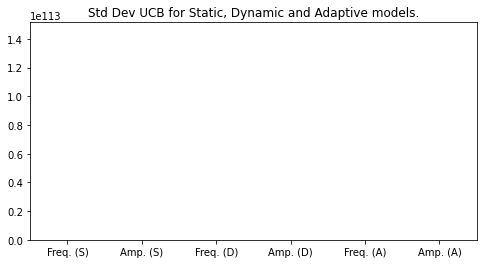

In [131]:
fig = plt.figure(figsize=(8,4));
sns.barplot(data=std_dev_ucb_df); 
plt.title("Std Dev UCB for Static, Dynamic and Adaptive models.");
plt.show();


In [132]:
std_dev_sim_df = pd.DataFrame({"Sim. Freq. (S)": static_sample_std[:,0],
                               "Sim. Amp. (S)": static_sample_std[:,1],
                               "Simu. Freq. (D)": dynamic_sample_std[:,0],
                               "Sim. Amp. (D)": dynamic_sample_std[:,1],
                               "Simu. Freq. (A)": adaptive_sample_std[:,0],
                               "Sim. Amp. (A)": adaptive_sample_std[:,1]})
display(std_dev_sim_df.head())

,Sim. Freq. (S),Sim. Amp. (S),Simu. Freq. (D),Sim. Amp. (D),Simu. Freq. (A),Sim. Amp. (A)
0,13.041536,18.634748,14.0,20.0,14.000000,126.423485
1,13.042597,18.634556,14.0,20.0,149.709789,147.794114
2,13.043641,18.636176,14.0,20.0,162.078744,150.377171
3,13.043888,18.637565,14.0,20.0,13.879201,19.765289
4,13.043822,18.634045,14.0,20.0,16.332789,19.043809


 C:\Users\sinad\anaconda3\envs\GP_env\lib\site-packages\numpy\lib\function_base.py:4009: RuntimeWarning:invalid value encountered in subtract


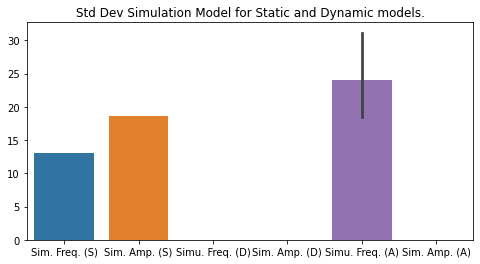

In [133]:
fig = plt.figure(figsize=(8,4));
sns.barplot(data=std_dev_sim_df); 
plt.title("Std Dev Simulation Model for Static and Dynamic models.");
plt.show();

In [134]:
# Mean UCB:
mean_ucb_df = pd.DataFrame({"Freq. (S)": static_ucb_mean[:,0],
                            "Amp. (S)": static_ucb_mean[:,1],
                            "Freq. (D)": dynamic_ucb_mean[:,0],
                            "Amp. (D)": dynamic_ucb_mean[:,1],
                            "Freq. (A)": adaptive_ucb_mean[:,0],
                            "Amp. (A)": adaptive_ucb_mean[:,1]})
display(mean_ucb_df.head())

,Freq. (S),Amp. (S),Freq. (D),Amp. (D),Freq. (A),Amp. (A)
0,24.166667,41.666667,23.802066,40.602066,23.802066,40.602066
1,29.166667,41.666667,23.802066,42.661210,23.802066,42.661210
2,29.166667,41.666667,30.661210,42.661210,30.661210,42.661210
3,29.166667,41.666667,30.672967,42.672967,30.672967,42.672967
4,29.166667,41.666667,28.241772,40.241772,28.241772,40.241772


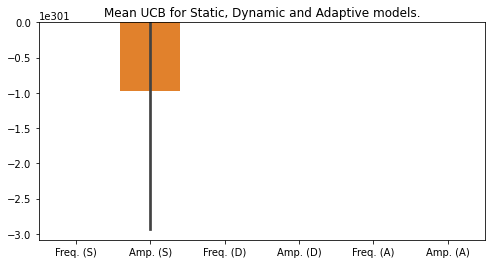

In [135]:
fig = plt.figure(figsize=(8,4));
sns.barplot(data=mean_ucb_df); 
plt.title("Mean UCB for Static, Dynamic and Adaptive models.");
plt.show();

In [136]:
# Mean Simulatino Model:
mean_sim_df = pd.DataFrame({"Freq. (S)": static_sample_mean[:,0],
                            "Amp. (S)": static_sample_mean[:,1],
                            "Freq. (D)": dynamic_sample_mean[:,0],
                            "Amp. (D)": dynamic_sample_mean[:,1],
                            "Freq. (A)": adaptive_sample_mean[:,0],
                            "Amp. (A)": adaptive_sample_mean[:,1]})
display(mean_sim_df.head())

,Freq. (S),Amp. (S),Freq. (D),Amp. (D),Freq. (A),Amp. (A)
0,29.167648,41.666288,28.0,40.0,28.000000,95.473368
1,29.167174,41.666373,28.0,40.0,109.854894,123.770313
2,29.166707,41.665649,28.0,40.0,105.612115,118.327114
3,29.166596,41.665028,28.0,40.0,20.366667,34.000000
4,29.166626,41.666602,28.0,40.0,27.800000,32.000000


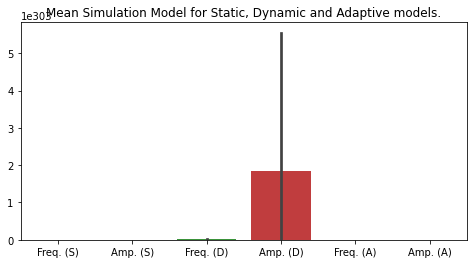

In [137]:
fig = plt.figure(figsize=(8,4));
sns.barplot(data=mean_sim_df); 
plt.title("Mean Simulation Model for Static, Dynamic and Adaptive models.");
plt.show();

##### 1.7.2: Acquisition plots

 C:\Users\sinad\AppData\Local\Temp\ipykernel_41548\936561862.py:15: UserWarning:The handle <matplotlib.collections.PolyCollection object at 0x0000015D0A6198B0> has a label of '_Hidden' which cannot be automatically added to the legend.
 C:\Users\sinad\AppData\Local\Temp\ipykernel_41548\936561862.py:15: UserWarning:The handle <matplotlib.collections.PolyCollection object at 0x0000015D0A619400> has a label of '_Hidden' which cannot be automatically added to the legend.
 C:\Users\sinad\AppData\Local\Temp\ipykernel_41548\936561862.py:41: UserWarning:The handle <matplotlib.collections.PolyCollection object at 0x0000015D0A4DB250> has a label of '_Hidden' which cannot be automatically added to the legend.
 C:\Users\sinad\AppData\Local\Temp\ipykernel_41548\936561862.py:41: UserWarning:The handle <matplotlib.collections.PolyCollection object at 0x0000015D0A4DBA30> has a label of '_Hidden' which cannot be automatically added to the legend.


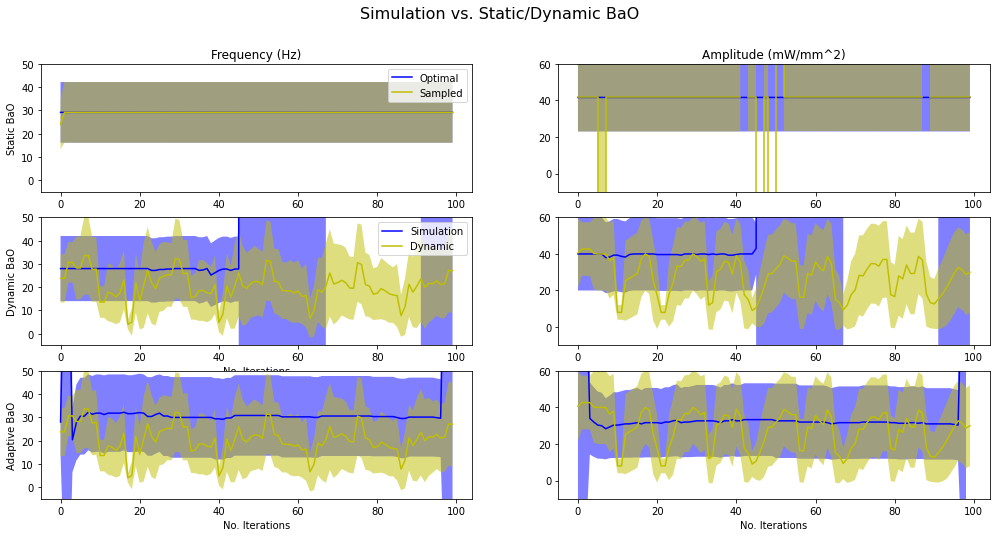

In [138]:
x_acquisitions = np.arange(0,n_acquisition)
fig = plt.figure(figsize=(17,8));
fig.suptitle("Simulation vs. Static/Dynamic BaO", fontsize=16)
plt.subplot(3,2,1)
plt.plot(x_acquisitions, static_sample_mean[:,0], label=r"frequency", color='b')
plt.fill_between(x_acquisitions, static_sample_mean[:,0]+static_sample_std[:,0],
                static_sample_mean[:,0]-static_sample_std[:,0], alpha=0.5, facecolor='b', label='_Hidden')
plt.plot(x_acquisitions, static_ucb_mean[:,0], label=r"frequency", color='y')
plt.fill_between(x_acquisitions, static_ucb_mean[:,0]+static_ucb_std[:,0],
                static_ucb_mean[:,0]-static_ucb_std[:,0], alpha=0.5, facecolor='y', label='_Hidden')
plt.ylim([-5, 50])
# plt.xlabel("No. Iterations")
plt.ylabel("Static BaO")
plt.title("Frequency (Hz)")
plt.legend(["Optimal", "_Hidden", "Sampled", "_Hidden"]);
# plt.grid(visible=True)

plt.subplot(3,2,2)
plt.plot(x_acquisitions, static_sample_mean[:,1], label=r"amplitude", color='b')
plt.fill_between(x_acquisitions, static_sample_mean[:,1]+static_sample_std[:,1],
                static_sample_mean[:,1]-static_sample_std[:,1], alpha=0.5, facecolor='b', label='_Hidden')
plt.plot(x_acquisitions, static_ucb_mean[:,1], label=r"amplitude", color='y')
plt.fill_between(x_acquisitions, static_ucb_mean[:,1]+static_ucb_std[:,1],
                static_ucb_mean[:,1]-static_ucb_std[:,1], alpha=0.5, facecolor='y', label='_Hidden')
plt.ylim([-10, 60])
# plt.xlabel("No. Iterations")
plt.title("Amplitude (mW/mm^2)")
# plt.legend(["Simulation", '_Hidden', "Static", '_Hidden']);
# plt.grid(visible=True)

plt.subplot(3,2,3)
plt.plot(x_acquisitions, dynamic_sample_mean[:,0], label=r"frequency", color='b')
plt.fill_between(x_acquisitions, dynamic_sample_mean[:,0]+dynamic_sample_std[:,0],
                dynamic_sample_mean[:,0]-dynamic_sample_std[:,0], alpha=0.5, facecolor='b', label='_Hidden')
plt.plot(x_acquisitions, dynamic_ucb_mean[:,0], label=r"frequency", color='y')
plt.fill_between(x_acquisitions, dynamic_ucb_mean[:,0]+dynamic_ucb_std[:,0],
                dynamic_ucb_mean[:,0]-dynamic_ucb_std[:,0], alpha=0.5, facecolor='y', label='_Hidden')
plt.ylim([-5, 50])
plt.xlabel("No. Iterations")
plt.ylabel("Dynamic BaO")
plt.legend(["Simulation", '_Hidden', "Dynamic", '_Hidden']);
# plt.grid(visible=True)

plt.subplot(3,2,4)
plt.plot(x_acquisitions, dynamic_sample_mean[:,1], label=r"amplitude", color='b')
plt.fill_between(x_acquisitions, dynamic_sample_mean[:,1]+dynamic_sample_std[:,1],
                dynamic_sample_mean[:,1]-dynamic_sample_std[:,1], alpha=0.5, facecolor='b', label='_Hidden')
plt.plot(x_acquisitions, dynamic_ucb_mean[:,1], label=r"amplitude", color='y')
plt.fill_between(x_acquisitions, dynamic_ucb_mean[:,1]+dynamic_ucb_std[:,1],
                dynamic_ucb_mean[:,1]-dynamic_ucb_std[:,1], alpha=0.5, facecolor='y', label='_Hidden')
plt.ylim([-10, 60])
# plt.xlabel("acquisition")
# plt.ylabel("amplitude")
# plt.legend(["Simulation", '_Hidden', "Dynamic", '_Hidden']);
# plt.grid(visible=True)

plt.subplot(3,2,5)
plt.plot(x_acquisitions, adaptive_sample_mean[:,0], label=r"frequency", color='b')
plt.fill_between(x_acquisitions, adaptive_sample_mean[:,0]+adaptive_sample_std[:,0],
                adaptive_sample_mean[:,0]-adaptive_sample_std[:,0], alpha=0.5, facecolor='b', label='_Hidden')
plt.plot(x_acquisitions, adaptive_ucb_mean[:,0], label=r"frequency", color='y')
plt.fill_between(x_acquisitions, adaptive_ucb_mean[:,0]+adaptive_ucb_std[:,0],
                adaptive_ucb_mean[:,0]-adaptive_ucb_std[:,0], alpha=0.5, facecolor='y', label='_Hidden')
plt.ylim([-5, 50])
plt.xlabel("No. Iterations")
plt.ylabel("Adaptive BaO")
# plt.legend(["Simulation", '_Hidden', "Adaptive", '_Hidden']);
# plt.grid(visible=True)

plt.subplot(3,2,6)
plt.plot(x_acquisitions, adaptive_sample_mean[:,1], label=r"amplitude", color='b')
plt.fill_between(x_acquisitions, adaptive_sample_mean[:,1]+adaptive_sample_std[:,1],
                adaptive_sample_mean[:,1]-adaptive_sample_std[:,1], alpha=0.5, facecolor='b', label='_Hidden')
plt.plot(x_acquisitions, adaptive_ucb_mean[:,1], label=r"amplitude", color='y')
plt.fill_between(x_acquisitions, adaptive_ucb_mean[:,1]+adaptive_ucb_std[:,1],
                adaptive_ucb_mean[:,1]-adaptive_ucb_std[:,1], alpha=0.5, facecolor='y', label='_Hidden')
plt.ylim([-10, 60])
plt.xlabel("No. Iterations")
# plt.ylabel("amplitude")
# plt.legend(["Simulation", '_Hidden', "Adaptive", '_Hidden']);
# plt.grid(visible=True)
plt.show();


In [139]:
static_variance_mean.shape

(100, 1)

 C:\Users\sinad\AppData\Local\Temp\ipykernel_41548\2748588689.py:14: UserWarning:The handle <matplotlib.collections.PolyCollection object at 0x0000015D0A728040> has a label of '_Hidden' which cannot be automatically added to the legend.
 C:\Users\sinad\AppData\Local\Temp\ipykernel_41548\2748588689.py:14: UserWarning:The handle <matplotlib.collections.PolyCollection object at 0x0000015D0A7288E0> has a label of '_Hidden' which cannot be automatically added to the legend.
 C:\Users\sinad\AppData\Local\Temp\ipykernel_41548\2748588689.py:27: UserWarning:The handle <matplotlib.collections.PolyCollection object at 0x0000015D0A76A6D0> has a label of '_Hidden' which cannot be automatically added to the legend.
 C:\Users\sinad\AppData\Local\Temp\ipykernel_41548\2748588689.py:27: UserWarning:The handle <matplotlib.collections.PolyCollection object at 0x0000015D0A76ADC0> has a label of '_Hidden' which cannot be automatically added to the legend.
 C:\Users\sinad\AppData\Local\Temp\ipykernel_41548\2

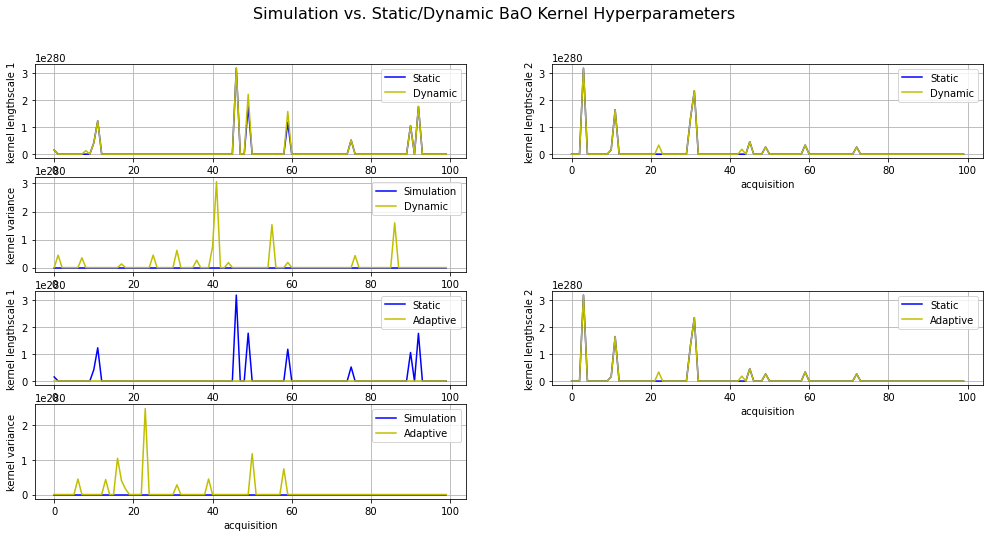

In [140]:
x_acquisitions = np.arange(0,n_acquisition)
fig = plt.figure(figsize=(17,8));
fig.suptitle("Simulation vs. Static/Dynamic BaO Kernel Hyperparameters", fontsize=16)
plt.subplot(4,2,1)
plt.plot(x_acquisitions, static_lengthscale_mean[0,:], label=r"frequency", color='b')
plt.fill_between(x_acquisitions, static_lengthscale_mean[0,:]+static_lengthscale_std[0,:],
                static_lengthscale_mean[0,:]-static_lengthscale_std[0,:], alpha=0.5, facecolor='b', label='_Hidden')
plt.plot(x_acquisitions, dynamic_lengthscale_mean[0,:], label=r"frequency", color='y')
plt.fill_between(x_acquisitions, dynamic_lengthscale_mean[0,:]+dynamic_lengthscale_std[0,:],
                dynamic_lengthscale_mean[0,:]-dynamic_lengthscale_std[0,:], alpha=0.5, facecolor='y', label='_Hidden')
# plt.ylim([-5, 50])
plt.xlabel("acquisition")
plt.ylabel("kernel lengthscale 1")
plt.legend(["Static", '_Hidden', "Dynamic", '_Hidden']);
plt.grid(visible=True)

plt.subplot(4,2,2)
plt.plot(x_acquisitions, static_lengthscale_mean[1,:], label=r"amplitude", color='b')
plt.fill_between(x_acquisitions, static_lengthscale_mean[1,:]+static_lengthscale_std[1,:],
                static_lengthscale_mean[1,:]-static_lengthscale_std[1,:], alpha=0.5, facecolor='b', label='_Hidden')
plt.plot(x_acquisitions, dynamic_lengthscale_mean[1,:], label=r"amplitude", color='y')
plt.fill_between(x_acquisitions, dynamic_lengthscale_mean[1,:]+dynamic_lengthscale_std[1,:],
                dynamic_lengthscale_mean[1,:]-dynamic_lengthscale_std[1,:], alpha=0.5, facecolor='y', label='_Hidden')
# plt.ylim([-5, 50])
plt.xlabel("acquisition")
plt.ylabel("kernel lengthscale 2")
plt.legend(["Static", '_Hidden', "Dynamic", '_Hidden']);
plt.grid(visible=True)

plt.subplot(4,2,3)
plt.plot(x_acquisitions, static_variance_mean[:,0], label=r"frequency", color='b')
plt.fill_between(x_acquisitions, static_variance_mean[:,0]+static_variance_std[:,0],
                static_variance_mean[:,0]-static_variance_std[:,0], alpha=0.5, facecolor='b', label='_Hidden')
plt.plot(x_acquisitions, dynamic_variance_mean[:,0], label=r"frequency", color='y')
plt.fill_between(x_acquisitions, dynamic_variance_mean[:,0]+dynamic_variance_std[:,0],
                dynamic_variance_mean[:,0]-dynamic_variance_std[:,0], alpha=0.5, facecolor='y', label='_Hidden')
# plt.ylim([-5, 50])
plt.xlabel("acquisition")
plt.ylabel("kernel variance")
plt.legend(["Simulation", '_Hidden', "Dynamic", '_Hidden']);
plt.grid(visible=True)

plt.subplot(4,2,5)
plt.plot(x_acquisitions, static_lengthscale_mean[0,:], label=r"frequency", color='b')
plt.fill_between(x_acquisitions, static_lengthscale_mean[0,:]+static_lengthscale_std[0,:],
                static_lengthscale_mean[0,:]-static_lengthscale_std[0,:], alpha=0.5, facecolor='b', label='_Hidden')
plt.plot(x_acquisitions, adaptive_lengthscale_mean[0,:], label=r"frequency", color='y')
plt.fill_between(x_acquisitions, adaptive_lengthscale_mean[0,:]+adaptive_lengthscale_std[0,:],
                adaptive_lengthscale_mean[0,:]-adaptive_lengthscale_std[0,:], alpha=0.5, facecolor='y', label='_Hidden')
# plt.ylim([-5, 50])
plt.xlabel("acquisition")
plt.ylabel("kernel lengthscale 1")
plt.legend(["Static", '_Hidden', "Adaptive", '_Hidden']);
plt.grid(visible=True)

plt.subplot(4,2,6)
plt.plot(x_acquisitions, static_lengthscale_mean[1,:], label=r"amplitude", color='b')
plt.fill_between(x_acquisitions, static_lengthscale_mean[1,:]+static_lengthscale_std[1,:],
                static_lengthscale_mean[1,:]-static_lengthscale_std[1,:], alpha=0.5, facecolor='b', label='_Hidden')
plt.plot(x_acquisitions, dynamic_lengthscale_mean[1,:], label=r"amplitude", color='y')
plt.fill_between(x_acquisitions, adaptive_lengthscale_mean[1,:]+adaptive_lengthscale_std[1,:],
                adaptive_lengthscale_mean[1,:]-adaptive_lengthscale_std[1,:], alpha=0.5, facecolor='y', label='_Hidden')
# plt.ylim([-5, 50])
plt.xlabel("acquisition")
plt.ylabel("kernel lengthscale 2")
plt.legend(["Static", '_Hidden', "Adaptive", '_Hidden']);
plt.grid(visible=True)

plt.subplot(4,2,7)
plt.plot(x_acquisitions, static_variance_mean[:,0], label=r"frequency", color='b')
plt.fill_between(x_acquisitions, static_variance_mean[:,0]+static_variance_std[:,0],
                static_variance_mean[:,0]-static_variance_std[:,0], alpha=0.5, facecolor='b', label='_Hidden')
plt.plot(x_acquisitions, adaptive_variance_mean[:,0], label=r"frequency", color='y')
plt.fill_between(x_acquisitions, adaptive_variance_mean[:,0]+adaptive_variance_std[:,0],
                adaptive_variance_mean[:,0]-adaptive_variance_std[:,0], alpha=0.5, facecolor='y', label='_Hidden')
# plt.ylim([-5, 50])
plt.xlabel("acquisition")
plt.ylabel("kernel variance")
plt.legend(["Simulation", '_Hidden', "Adaptive", '_Hidden']);
plt.grid(visible=True)

plt.show();

#### 1.7.3 Number of samples to converge

In [141]:
derivative_static_freq = np.gradient(static_ucb_mean[:,0])
idx_derivative_satic_freq = np.where(derivative_static_freq==0)
print("The derivative of Static Freq is: ", derivative_static_freq, "\n index where static freq plateaus: ", idx_derivative_satic_freq)

derivative_static_amp = np.gradient(static_ucb_mean[:,1])
idx_derivative_satic_amp = np.where(derivative_static_amp==0)
print("The derivative of Static Amp is: ", derivative_static_amp, "\n index where static freq plateaus: ", idx_derivative_satic_amp)

idx_plateau_static_freq = []
idx_plateau_static_amp = []
# print(np.size(idx_derivative_satic_freq), np.shape(idx_plateau_static_freq))
for p in range(0, n_acquisition):
    if derivative_static_freq[p:p+1]==0. :
        idx_plateau_static_freq = np.append(idx_plateau_static_freq,[p+1])
        # print(p, '\n ', idx_plateau_static_freq)
    if derivative_static_amp[p:p+1]==0. :
        idx_plateau_static_amp = np.append(idx_plateau_static_amp,[p+1])
        
print("The idx of first plateau for static model with length 2 sample for freq is: ", idx_plateau_static_freq[0]) 
print("The idx of first plateau static model with length 2 sample for amp is: ", idx_plateau_static_amp[0]) 

The derivative of Static Freq is:  [5.  2.5 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
 0.  0.  0.  0.  0.  0.  0.  0.  0.  0. ] 
 index where static freq plateaus:  (array([ 2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18,
       19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35,
       36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52,
       53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69,
       70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86,
       87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99], dtype=int64),)
The derivative of Static Amp is:  [ 0.00000000e+000  0.00000000e+000  0.000

In [142]:
derivative_dynamic_freq = np.gradient(dynamic_ucb_mean[:,0])
idx_derivative_dynamic_freq = np.where(derivative_dynamic_freq==0)
print("The derivative of dynamic Freq is: ", derivative_dynamic_freq, "\n index where dynamic freq plateaus: ", idx_derivative_dynamic_freq)

derivative_dynamic_amp = np.gradient(dynamic_ucb_mean[:,1])
idx_derivative_dynamic_amp = np.where(derivative_dynamic_amp==0)
print("The derivative of dynamic Amp is: ", derivative_dynamic_amp, "\n index where dynamic freq plateaus: ", idx_derivative_dynamic_amp)

idx_plateau_dynamic_freq = []
idx_plateau_dynamic_amp = []
# print(np.size(idx_derivative_satic_freq), np.shape(idx_plateau_static_freq))
for p in range(0, n_acquisition):
    if derivative_dynamic_freq[p:p+1]==0. :
        idx_plateau_dynamic_freq = np.append(idx_plateau_dynamic_freq,[p+1])
        # print(p, '\n ', idx_plateau_static_freq)
    if derivative_dynamic_amp[p:p+1]==0. :
        idx_plateau_dynamic_amp = np.append(idx_plateau_dynamic_amp,[p+1])
        
print("The idx of first plateau for dynamic model with length 2 sample for freq is: ", idx_plateau_dynamic_freq[0]) 
print("The idx of first plateau dynamic model with length 2 sample for amp is: ", idx_plateau_dynamic_amp[0]) 

The derivative of dynamic Freq is:  [ 0.          3.42957193  3.43545079 -1.20971866 -1.21559751  2.67911383
  2.67911383 -3.         -2.9        -7.         -7.1         2.1
  1.8        -1.          0.2         3.7        -6.8        -9.1
  8.9         4.56666667 -0.53333333  6.58333333  0.58333333 -3.98333333
  1.          2.68333333  0.75        0.25        3.46666667  3.35
 -3.25       -2.93333333 -5.21666667 -5.01666667  1.6         1.3
 -0.5        -0.7         1.7        -6.2        -6.3         7.88333333
  3.65       -0.03333333  5.15        0.03333333 -3.28333333  0.46666667
  1.55        0.38333333 -0.73333333  4.61666667  5.         -4.43333333
 -4.41666667 -2.         -1.9        -0.11666667 -0.41666667 -0.1
 -0.78333333 -0.88333333 -4.7        -3.31666667  6.11666667  3.98333333
  0.75        4.18333333  0.5        -2.08333333  0.8         0.
 -1.65       -1.23333333  5.45        5.13333333 -4.73333333 -4.63333333
 -2.05       -1.55        1.2         0.5        -1.1    

In [143]:
idx_static_vs_dynamic_freq = idx_plateau_dynamic_freq[0] - idx_plateau_static_freq[0]
idx_static_vs_dynamic_amp = idx_plateau_dynamic_amp[0] - idx_plateau_static_amp[0]

print("the dynamic freq plateaus at sample %d after the static sample.", idx_static_vs_dynamic_freq)
print("the dynamic amp plateaus at sample %d after the static sample.", idx_static_vs_dynamic_amp)

the dynamic freq plateaus at sample %d after the static sample. -2.0
the dynamic amp plateaus at sample %d after the static sample. 6.0


In [144]:
print(np.shape(idx_plateau_static_freq),
     np.shape(idx_plateau_static_amp),
     np.shape(idx_plateau_dynamic_freq),
     np.shape(idx_plateau_dynamic_amp))

(98,) (87,) (2,) (1,)


<AxesSubplot:>

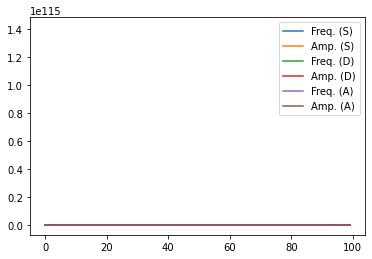

In [145]:
# number of samples to converge:
std_dev_ucb_df.plot.line()

In [146]:
std_dev_ucb_df.describe()

,Freq. (S),Amp. (S),Freq. (D),Amp. (D),Freq. (A),Amp. (A)
count,100.000000,98.0000,100.000000,100.000000,100.000000,100.000000
mean,13.021369,inf,13.697337,19.012612,13.697337,19.012612
std,0.223607,NaN,3.220473,4.356396,3.220473,4.356396
min,10.807662,18.6339,2.000000,4.000000,2.000000,4.000000
25%,13.043730,18.6339,12.309109,17.955666,12.309109,17.955666
50%,13.043730,18.6339,13.754282,20.752510,13.754282,20.752510
75%,13.043730,18.6339,15.485953,21.768989,15.485953,21.768989
max,13.043730,inf,18.796690,22.350739,18.796690,22.350739


In [147]:
std_dev_static_freq_converge = std_dev_ucb_df.loc[std_dev_ucb_df['Freq. (S)']<std_dev_ucb_df['Freq. (S)'].mean(),['Freq. (S)']].index
std_dev_static_amp_converge = std_dev_ucb_df.loc[std_dev_ucb_df['Amp. (S)']<std_dev_ucb_df['Amp. (S)'].mean(),['Amp. (S)']].index

std_dev_dynamic_freq_converge = std_dev_ucb_df.loc[std_dev_ucb_df['Freq. (D)']<std_dev_ucb_df['Freq. (D)'].mean(),['Freq. (D)']].index
std_dev_dynamic_amp_converge = std_dev_ucb_df.loc[std_dev_ucb_df['Amp. (D)']<std_dev_ucb_df['Amp. (D)'].mean(),['Amp. (D)']].index
print('std_dev_static_freq_converge \n', std_dev_static_freq_converge)
print('std_dev_static_amp_converge \n', std_dev_static_amp_converge)
print('std_dev_dynamic_freq_converge \n', std_dev_dynamic_freq_converge)
print('std_dev_dynamic_amp_converge \n', std_dev_dynamic_amp_converge)

std_dev_static_freq_converge 
 Int64Index([0], dtype='int64')
std_dev_static_amp_converge 
 Int64Index([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
            17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
            34, 35, 36, 37, 38, 39, 40, 41, 43, 44, 45, 47, 48, 50, 52, 53, 54,
            55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71,
            72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 89,
            90, 91, 92, 93, 94, 95, 96, 97, 98, 99],
           dtype='int64')
std_dev_dynamic_freq_converge 
 Int64Index([ 0,  1,  2,  3,  4,  5, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20,
            28, 33, 34, 35, 36, 37, 38, 39, 40, 41, 43, 56, 57, 58, 59, 60, 61,
            63, 64, 73, 74, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87],
           dtype='int64')
std_dev_dynamic_amp_converge 
 Int64Index([ 0,  1,  2,  3, 10, 11, 20, 21, 22, 23, 33, 34, 42, 43, 44, 45, 46,
            56, 57, 65, 66,

In [148]:
print(np.shape(std_dev_static_freq_converge),
     np.shape(std_dev_static_amp_converge),
     np.shape(std_dev_dynamic_freq_converge),
     np.shape(std_dev_dynamic_amp_converge))

(1,) (95,) (49,) (31,)


#### 1.7.4: Comparing the Simulation with Static/Dynamic models using Normalized Mean-Squared-Error (NMSE).

$$NMSE(GP_{est}, GP_{sim})= \frac{||\mu_{est}(x)-\mu_{sim}(s)||_2^2}{||\mu_{sim}(x)||_2^2} $$

In [149]:
nmse_static_simulatinon_freq = np.square(np.subtract(static_ucb_mean[:,0], static_sample_mean[:, 0])).mean()/(np.square(static_sample_mean[:, 0])).mean()
nmse_static_simulatinon_freq = np.round(nmse_static_simulatinon_freq, 4)
print("nmse_static_simulatinon_freq: ", nmse_static_simulatinon_freq)
nmse_static_simulatinon_amp = np.square(np.subtract(static_ucb_mean[:,1], static_sample_mean[:, 1])).mean()/(np.square(static_sample_mean[:, 1])).mean()
nmse_static_simulatinon_amp = np.round(nmse_static_simulatinon_amp, 4)
print("nmse_static_simulatinon_amp: ", nmse_static_simulatinon_amp, '\n')

nmse_dynamic_simulatinon_freq = np.square(np.subtract(dynamic_ucb_mean[:,0], dynamic_sample_mean[:, 0])).mean()/(np.square(dynamic_sample_mean[:, 0])).mean()
nmse_dynamic_simulatinon_freq = np.round(nmse_dynamic_simulatinon_freq, 4)
print("nmse_dynamic_simulatinon_freq: ", nmse_dynamic_simulatinon_freq)
nmse_dynamic_simulatinon_amp = np.square(np.subtract(dynamic_ucb_mean[:,0], dynamic_sample_mean[:, 1])).mean()/(np.square(dynamic_sample_mean[:, 1])).mean()
nmse_dynamic_simulatinon_amp = np.round(nmse_dynamic_simulatinon_amp, 4)
print("nmse_dynamic_simulatinon_amp: ", nmse_dynamic_simulatinon_amp)

nmse_static_simulatinon_freq:  0.0003
nmse_static_simulatinon_amp:  nan 

nmse_dynamic_simulatinon_freq:  nan
nmse_dynamic_simulatinon_amp:  nan


 C:\Users\sinad\AppData\Local\Temp\ipykernel_41548\4058500017.py:4: RuntimeWarning:overflow encountered in square
 C:\Users\sinad\AppData\Local\Temp\ipykernel_41548\4058500017.py:8: RuntimeWarning:overflow encountered in square
 C:\Users\sinad\AppData\Local\Temp\ipykernel_41548\4058500017.py:8: RuntimeWarning:invalid value encountered in double_scalars
 C:\Users\sinad\AppData\Local\Temp\ipykernel_41548\4058500017.py:11: RuntimeWarning:overflow encountered in square
 C:\Users\sinad\AppData\Local\Temp\ipykernel_41548\4058500017.py:11: RuntimeWarning:invalid value encountered in double_scalars


In [150]:
print(np.shape(static_ucb_std))

(100, 3)


In [151]:
# Post stimulation Gamma comparison plots

postStim_gamma_df = pd.DataFrame({"Simulation S": simulation_postStimGamma_predicted.flatten('C'),
                                 "Static": static_postStimGamma_predicted.flatten('C'),
                                 "Simulation D": simulation_postStimGamma_predicted_d.flatten('C'),
                                 "Dynamic": dynamic_postStimGamma_predicted.flatten('C')})
postStim_gamma_df.head()

,Simulation S,Static,Simulation D,Dynamic
0,48.529290,7.878055,43.379140,14.064654
1,44.414550,8.195004,41.645262,19.540558
2,39.617060,17.332263,42.991627,10.573116
3,45.283441,11.498723,47.470260,19.148424
4,42.980700,12.596886,40.000202,21.965011


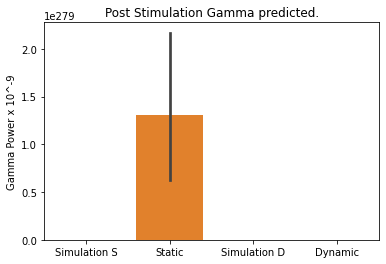

In [152]:
sns.barplot(data=postStim_gamma_df);
plt.ylabel("Gamma Power x 10^-9");
plt.title("Post Stimulation Gamma predicted.");
plt.show();

#### Next make the bayes_opt_update_state_dr()
function X_new_sample = bayes_opt_update_state_dr(objective_est, input_space, acquisition_function, acq_params, t)

[Y_mean, ~, ~, Y_uncertainty] = objective_est.predict(input_space);

switch acquisition_function
    case 'PI'
        acq_value = predicted_improvement(Y_mean, Y_uncertainty, acq_params); % TODO
    case 'EI'
        acq_value = expected_improvement(Y_mean, Y_uncertainty, acq_params); % TODO
    case 'UCB'
        acq_value = upper_confidence_bound(Y_mean, Y_uncertainty, acq_params, t);
end

[~, max_idx] = max(acq_value);

X_new_sample = input_space(max_idx,:);

end